In [1]:
import sys, os, re, copy
import dill as pickle # this serializes all the functions inside the quantification dict
import numpy as np
import scipy as sp
from natsort import natsorted
from scipy.optimize import newton, minimize, fsolve
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.colors as mcolors
import matplotlib.ticker as tck
from matplotlib.gridspec import GridSpec
palette = list(mcolors.TABLEAU_COLORS.keys())
%matplotlib inline
import seaborn as sns
sns.set_style("whitegrid", {
 'axes.spines.bottom': True,
 'axes.spines.left': True,
 'axes.spines.right': True,
 'axes.spines.top': True
})
sns.set(font_scale=1)
palette = list(mcolors.TABLEAU_COLORS.keys())
#sns.set_theme(style="ticks", palette="muted")
sns.set_style("whitegrid")
sns.set_theme(style="ticks", palette="muted")
sns.set_context("notebook", font_scale=1.5)

# Plot temporal Asp-sensor signal

### Read data and annotations

In [2]:
data_folder = 'IC_data'
anno_sheet = 'Asp-sens_temporal-annotations.xlsx'

In [3]:
well_anno = pd.read_excel(anno_sheet)
conc_res = list()
for c, r in zip(well_anno['Conc'], well_anno['Rescue']):
    if int(c) == c:
        if r != 'None':
            conc_res.append('{} + {}'.format(int(c), r))
        else:
            conc_res.append('{}'.format(int(c)))
    else:
        if r != 'None':
            conc_res.append('{} + {}'.format(c, r))
        else:
            conc_res.append('{}'.format(c))
well_anno['conc_res'] = conc_res

conc_time = list()
for d, t, c in zip(well_anno['Drug'], well_anno['Drug time'], well_anno['Conc']):
    conc_time.append('{} mM - {} h'.format(int(c), int(t)))
well_anno['conc_time'] = conc_time


drug_conc_resc = list()
for d, r, c in zip(well_anno['Drug'], well_anno['Rescue'], well_anno['Rescue conc']):
    if r[0:3].lower() == 'vec':
        drug_conc_resc.append('{} - Vec'.format(d, int(c)))
    else:
        drug_conc_resc.append('{} - {} nM'.format(d, int(c)))
well_anno['drug_conc_resc'] = drug_conc_resc

conc_resc = list()
for r, c in zip(well_anno['Rescue'], well_anno['Rescue conc']):
    if r[0:3].lower() == 'vec':
        conc_resc.append('Vec')
    else:
        conc_resc.append('{} nM'.format(int(c)))
well_anno['conc_resc'] = conc_resc


drug_resc_time = list()
for d, r, t in zip(well_anno['Drug'], well_anno['Rescue'], well_anno['Rescue time']):
    drug_resc_time.append('{} & {} - {} h'.format(d, r, int(t)))
well_anno['drug_resc_time'] = drug_resc_time


conc_drug = list()
for c, r in zip(well_anno['Conc'], well_anno['Drug']):
    if int(c) == c:
        if r != 'None':
            conc_drug.append('{} + {}'.format(int(c), r))
        else:
            conc_drug.append('{}'.format(int(c)))
    else:
        if r != 'None':
            conc_drug.append('{} + {}'.format(c, r))
        else:
            conc_drug.append('{}'.format(c))
well_anno['conc_drug'] = conc_drug

well_ids = natsorted(list(set(well_anno['Well'])))
well_anno.head(2)

,Folder name,Plate name,Cell line,Well,Drug,Drug time,Conc,Conc unit,Rescue,Rescue time,...,ci,rfp fold cut,include,conf cut,conc_res,conc_time,drug_conc_resc,conc_resc,drug_resc_time,conc_drug
0,AS_P6,AS_P6,H1299 GOT-DKO Nuc-RFP Asp-sens,A1,Aspartate,0,40.0,mM,None,0,...,95,10,True,101,40,40 mM - 0 h,Aspartate - 0 nM,0 nM,Aspartate & None - 0 h,40 + Aspartate
1,AS_P6,AS_P6,H1299 GOT-DKO Nuc-RFP Asp-sens,B1,Aspartate,0,40.0,mM,None,0,...,95,10,True,101,40,40 mM - 0 h,Aspartate - 0 nM,0 nM,Aspartate & None - 0 h,40 + Aspartate


In [4]:
plate_anno = well_anno.groupby(['Folder name', 'Plate name']).agg('max').reset_index()
plate_anno.head(2)

,Folder name,Plate name,Cell line,Well,Drug,Drug time,Conc,Conc unit,Rescue,Rescue time,...,ci,rfp fold cut,include,conf cut,conc_res,conc_time,drug_conc_resc,conc_resc,drug_resc_time,conc_drug
0,AS_P10,AS_P10,HT1080 Nuc-RFP Asp-sens,D6,Rotenone,0,200.0,nM,Pyr,0,...,95,10,True,101,50,50 mM - 0 h,Rotenone - 2 nM,2 nM,Rotenone & Pyr - 0 h,50 + Rotenone
1,AS_P11,AS_P11,HT1080 Asp-sens-RFP,D6,Rotenone,0,200.0,nM,Pyr,0,...,95,10,True,101,50,50 mM - 0 h,Rotenone - 0 nM,0 nM,Rotenone & Pyr - 0 h,50 + Rotenone


### Plot all plates to get an overview
Below plot the temporal Asp-sensor response for all the plates using a for loop.
Some of the plot annotations, e.g. legend text is not always right.
See below for plotting of individual plates.

IC_data/AS_P10/AS_P10_all.xlsx
IC_data/AS_P11/AS_P11_all.xlsx
IC_data/AS_P12/AS_P12_all.xlsx
IC_data/AS_P13/AS_P13_all.xlsx


KeyboardInterrupt: 

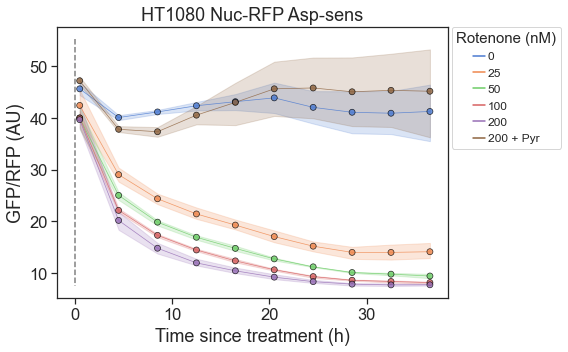

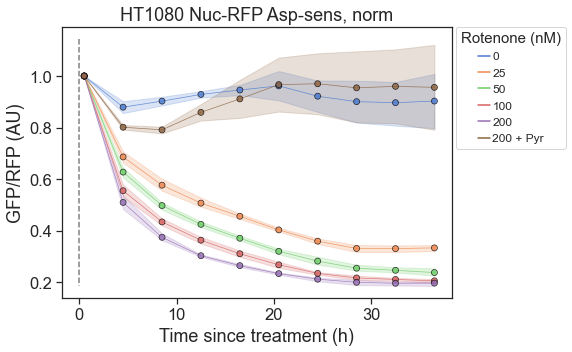

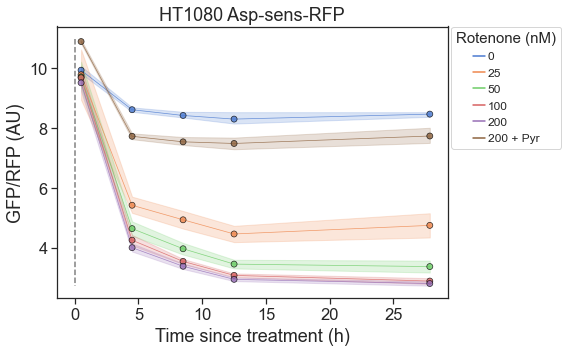

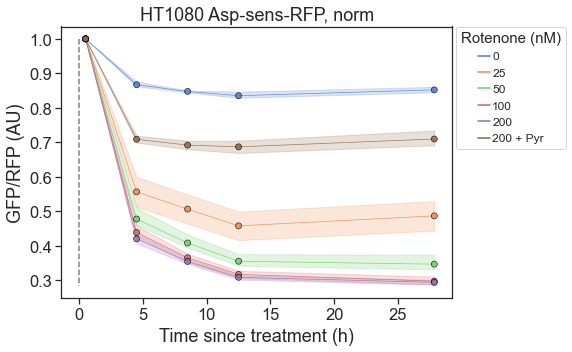

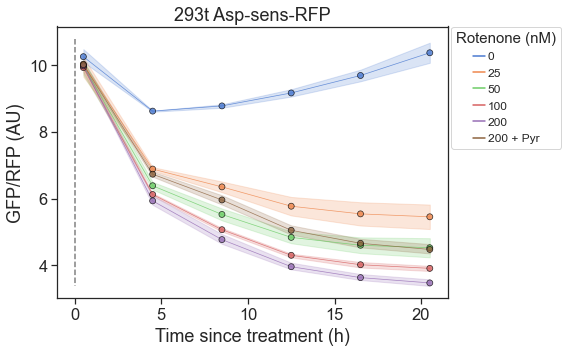

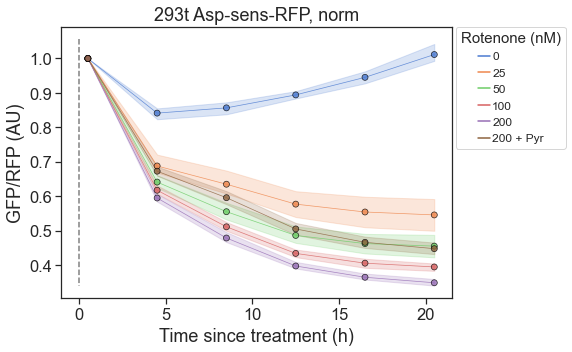

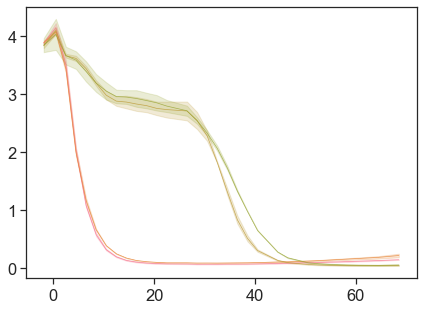

In [5]:
for _, row in plate_anno.iterrows():
    fnam, pnam = row['Folder name'], row['Plate name']
    Nmes_pre, t_to_mes = row['Nmes pre'], row['Time to mes']
    
    wb_name = '{}/{}/{}_all.xlsx'.format(data_folder, fnam, pnam)
    sheet_name = '{}_GFP-RFP'.format(pnam)
    sheet_name_rfp = '{}_RFP'.format(pnam)
    sheet_name_conf = '{}_conf'.format(pnam)
    print(wb_name)
    #print(sheet_name)
    df = pd.read_excel(wb_name, header=1, sheet_name=sheet_name)
    # Fix treatment time and mask useless timepoints:
    df['Elapsed'] = df['Elapsed'] - df['Elapsed'].values[Nmes_pre] + t_to_mes
    time_mask = df['Elapsed'] < row['max time']
    df = df[time_mask].copy()
    
    # Find the columns for the plate:
    df_melt = df.melt(['Date Time', 'Elapsed'], value_name='GFP/RFP', var_name='Well')
    well_ids = natsorted(list(set(df_melt['Well'])))

    # Mask timepoint with confluent cells:
    df_rfp = pd.read_excel(wb_name, header=1, sheet_name=sheet_name_rfp)
    df_rfp = df_rfp[time_mask].copy()
    df_rfp.loc[:, well_ids] = df_rfp.loc[:, well_ids] / df_rfp.loc[0, well_ids]
    df_conf = pd.read_excel(wb_name, header=1, sheet_name=sheet_name_conf)
    cut_mask = (df_rfp.loc[:, well_ids] < row['rfp fold cut']) & (df_conf.loc[:, well_ids] < row['conf cut'])
    df.loc[:, well_ids] = df.loc[:, well_ids][cut_mask].copy()
    
    
    df_melt = df.melt(['Date Time', 'Elapsed'], value_name='GFP/RFP', var_name='Well')
    df_melt = df_melt[~df_melt.isna()].copy()
    df_norm = df.copy()
    df_norm.loc[:, well_ids] = df.loc[:, well_ids] / df.loc[0, well_ids]
    df_norm_melt = df_norm.melt(['Date Time', 'Elapsed'], value_name='GFP/RFP', var_name='Well')
    df_norm_melt = df_norm_melt[~df_norm_melt.isna()].copy()
    anno_mask = (well_anno['Folder name'] == fnam) & (well_anno['Plate name'] == pnam)
    plate_data = well_anno[anno_mask].merge(df_melt, on='Well').reset_index(drop=True)
    plate_data_norm = well_anno[anno_mask].merge(df_norm_melt, on='Well').reset_index(drop=True)
    plate_data['GFP/RFP norm'] = plate_data_norm['GFP/RFP'].copy()
    # Remove non-included wells:
    plate_data = plate_data[plate_data['include']].copy()
    grp_cols = list(set(plate_data.columns) - set(['GFP/RFP', 'GFP/RFP norm', 'Well']))
    plate_data_avg = plate_data.groupby(grp_cols).agg(GFP_RFP_mean=('GFP/RFP', 'mean'), 
                                                      GFP_RFP_std=('GFP/RFP', 'std'), 
                                                      GFP_RFP_norm_mean=('GFP/RFP norm', 'mean'), 
                                                      GFP_RFP_norm_std=('GFP/RFP norm', 'std')).reset_index()

    if len(set(plate_data['Drug'])) > 1:
        style = 'Drug'
        markers = True
    elif len(set(plate_data['Rescue'])) > 1 and not 'Pyr' in set(plate_data['Rescue']):
        style = 'Rescue'
        markers = True
    elif len(set(plate_data['Drug time'])) > 1:
        style = 'Drug time'
        markers = True
    elif not row['scatter']:
        style = 'Drug'
        markers = True
    else:
        style = 'None'
        markers = False
    
    for pmode in ['GFP/RFP', 'GFP/RFP norm']:
        min_sens = plate_data[pmode].min()
        max_sens = plate_data[pmode].max()
        hue_order = natsorted(set(plate_data['conc_res']))
        
        fig, ax1 = plt.subplots(1, 1, figsize=(7, 5))
        g1 = sns.lineplot(ax=ax1, data=plate_data, y=pmode, x='Elapsed', hue='conc_res', \
                          zorder=9, alpha=0.8, linewidth=0.7, legend=True, \
                          errorbar=('ci', row['ci']), hue_order=hue_order)
        if row['scatter']:
            g2 = sns.scatterplot(ax=ax1, data=plate_data, y=pmode, x='Elapsed', hue='conc_res', \
                                 zorder=10, alpha=0.8, edgecolor='black', linewidth=0.7, \
                                 legend=False, markers=markers, style=style, hue_order=hue_order)
        else:
            if 'norm' in pmode:
                pmode_avg = 'GFP_RFP_norm_mean'
            else:
                pmode_avg = 'GFP_RFP_mean'
            g2 = sns.scatterplot(ax=ax1, data=plate_data_avg, y=pmode_avg, x='Elapsed', hue='conc_res', \
                                 zorder=10, alpha=0.8, edgecolor='black', linewidth=0.7, \
                                 legend=False, markers=markers, style=style, hue_order=hue_order)

        g1.set_ylabel('GFP/RFP (AU)')
        g1.set_xlabel('Time since treatment (h)')
        if 'norm' in pmode:
            g1.set_title('{}, norm'.format(row['Cell line']))
        else:
            g1.set_title(row['Cell line'])
        sns.move_legend(g1, "upper left", bbox_to_anchor=(1.01, 1), frameon=True, ncol=1, \
                        alignment='center', labelspacing=0.5, handletextpad=0.2, borderaxespad=0, \
                        handlelength=1, title='{} ({})'.format(row['Drug'], row['Conc unit']), \
                        fontsize=12, title_fontsize=15)

        ax1.vlines(0, max_sens, min_sens, ls='--', color='grey')


### HT1080 Nuc-RFP Asp-sens Rotenone titration

IC_data/AS_P10/AS_P10_all.xlsx


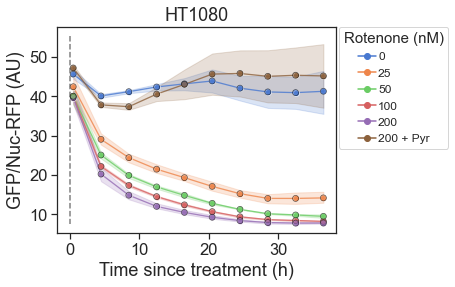

In [6]:
plate_name_sele = 'AS_P10'



row_found = False
for _, row in plate_anno.iterrows():
    if row['Plate name'] == plate_name_sele:
        row_found = True
        break
assert(row_found)
    
fnam, pnam = row['Folder name'], row['Plate name']
Nmes_pre, t_to_mes = row['Nmes pre'], row['Time to mes']

wb_name = '{}/{}/{}_all.xlsx'.format(data_folder, fnam, pnam)
sheet_name = '{}_GFP-RFP'.format(pnam)
sheet_name_rfp = '{}_RFP'.format(pnam)
print(wb_name)
#print(sheet_name)
df = pd.read_excel(wb_name, header=1, sheet_name=sheet_name)
# Fix treatment time and mask useless timepoints:
df['Elapsed'] = df['Elapsed'] - df['Elapsed'].values[Nmes_pre] + t_to_mes
time_mask = df['Elapsed'] < row['max time']
df = df[time_mask].copy()

# Find the columns for the plate:
df_melt = df.melt(['Date Time', 'Elapsed'], value_name='GFP/RFP', var_name='Well')
well_ids = natsorted(list(set(df_melt['Well'])))

# Mask timepoint with confluent cells:
df_rfp = pd.read_excel(wb_name, header=1, sheet_name=sheet_name_rfp)
df_rfp = df_rfp[time_mask].copy()
df_rfp.loc[:, well_ids] = df_rfp.loc[:, well_ids] / df_rfp.loc[0, well_ids]

cut_mask = df_rfp.loc[:, well_ids] < row['rfp fold cut']
df.loc[:, well_ids] = df.loc[:, well_ids][cut_mask].copy()


df_melt = df.melt(['Date Time', 'Elapsed'], value_name='GFP/RFP', var_name='Well')
df_melt = df_melt[~df_melt.isna()].copy()
df_norm = df.copy()
df_norm.loc[:, well_ids] = df.loc[:, well_ids] / df.loc[0, well_ids]
df_norm_melt = df_norm.melt(['Date Time', 'Elapsed'], value_name='GFP/RFP', var_name='Well')
df_norm_melt = df_norm_melt[~df_norm_melt.isna()].copy()
anno_mask = (well_anno['Folder name'] == fnam) & (well_anno['Plate name'] == pnam)
plate_data = well_anno[anno_mask].merge(df_melt, on='Well').reset_index(drop=True)
plate_data_norm = well_anno[anno_mask].merge(df_norm_melt, on='Well').reset_index(drop=True)
plate_data['GFP/RFP norm'] = plate_data_norm['GFP/RFP'].copy()
# Remove non-included wells:
plate_data = plate_data[plate_data['include']].copy()
grp_cols = list(set(plate_data.columns) - set(['GFP/RFP', 'GFP/RFP norm', 'Well']))
plate_data_avg = plate_data.groupby(grp_cols).agg(GFP_RFP_mean=('GFP/RFP', 'mean'), 
                                                  GFP_RFP_std=('GFP/RFP', 'std'), 
                                                  GFP_RFP_norm_mean=('GFP/RFP norm', 'mean'), 
                                                  GFP_RFP_norm_std=('GFP/RFP norm', 'std')).reset_index()


style = 'Drug'
markers = True
pmode = 'GFP/RFP'
pmode_avg = 'GFP_RFP_mean'
min_sens = plate_data[pmode].min()
max_sens = plate_data[pmode].max()
hue_order = natsorted(set(plate_data['conc_res']))

fig, ax1 = plt.subplots(1, 1, figsize=(5, 3.8))
g1 = sns.lineplot(ax=ax1, data=plate_data, y=pmode, x='Elapsed', hue='conc_res', style='conc_res', \
                  zorder=9, alpha=0.8, linewidth=1.3, legend=True, \
                  errorbar=('ci', row['ci']), hue_order=hue_order, \
                  markers=["o"]*len(hue_order), dashes=[""]*len(hue_order))

g2 = sns.scatterplot(ax=ax1, data=plate_data_avg, y=pmode_avg, x='Elapsed', hue='conc_res', \
                     zorder=10, alpha=0.6, edgecolor='black', linewidth=0.7, \
                     legend=False, markers=markers, style=style, hue_order=hue_order)

g2.set_ylabel('GFP/Nuc-RFP (AU)')
g2.set_xlabel('Time since treatment (h)')
g2.set_title('HT1080')
sns.move_legend(g2, "upper left", bbox_to_anchor=(1.01, 1), frameon=True, ncol=1, \
                alignment='center', labelspacing=0.5, handletextpad=0.2, borderaxespad=0, \
                handlelength=1.5, title='{} ({})'.format(row['Drug'], row['Conc unit']), \
                fontsize=12, title_fontsize=15)

ax1.vlines(0, max_sens, min_sens, ls='--', color='grey')


pdf_fnam = 'temporal_plots/{}.pdf'.format(plate_name_sele)
fig.savefig(pdf_fnam, bbox_inches='tight')

HT1080_Nuc_RFP_df = copy.deepcopy(plate_data_avg)

### HT1080 Asp-sens-RFP Rotenone titration

IC_data/AS_P11/AS_P11_all.xlsx


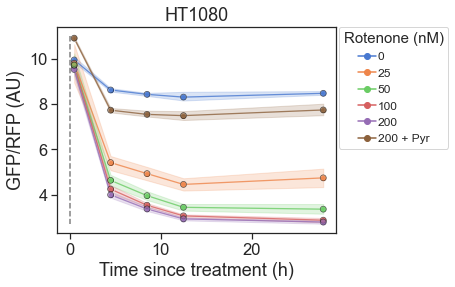

In [7]:
plate_name_sele = 'AS_P11'



row_found = False
for _, row in plate_anno.iterrows():
    if row['Plate name'] == plate_name_sele:
        row_found = True
        break
assert(row_found)
    
fnam, pnam = row['Folder name'], row['Plate name']
Nmes_pre, t_to_mes = row['Nmes pre'], row['Time to mes']

wb_name = '{}/{}/{}_all.xlsx'.format(data_folder, fnam, pnam)
sheet_name = '{}_GFP-RFP'.format(pnam)
sheet_name_rfp = '{}_RFP'.format(pnam)
print(wb_name)
#print(sheet_name)
df = pd.read_excel(wb_name, header=1, sheet_name=sheet_name)
# Fix treatment time and mask useless timepoints:
df['Elapsed'] = df['Elapsed'] - df['Elapsed'].values[Nmes_pre] + t_to_mes
time_mask = df['Elapsed'] < row['max time']
df = df[time_mask].copy()

# Find the columns for the plate:
df_melt = df.melt(['Date Time', 'Elapsed'], value_name='GFP/RFP', var_name='Well')
well_ids = natsorted(list(set(df_melt['Well'])))

# Mask timepoint with confluent cells:
df_rfp = pd.read_excel(wb_name, header=1, sheet_name=sheet_name_rfp)
df_rfp = df_rfp[time_mask].copy()
df_rfp.loc[:, well_ids] = df_rfp.loc[:, well_ids] / df_rfp.loc[0, well_ids]

cut_mask = df_rfp.loc[:, well_ids] < row['rfp fold cut']
df.loc[:, well_ids] = df.loc[:, well_ids][cut_mask].copy()


df_melt = df.melt(['Date Time', 'Elapsed'], value_name='GFP/RFP', var_name='Well')
df_melt = df_melt[~df_melt.isna()].copy()
df_norm = df.copy()
df_norm.loc[:, well_ids] = df.loc[:, well_ids] / df.loc[0, well_ids]
df_norm_melt = df_norm.melt(['Date Time', 'Elapsed'], value_name='GFP/RFP', var_name='Well')
df_norm_melt = df_norm_melt[~df_norm_melt.isna()].copy()
anno_mask = (well_anno['Folder name'] == fnam) & (well_anno['Plate name'] == pnam)
plate_data = well_anno[anno_mask].merge(df_melt, on='Well').reset_index(drop=True)
plate_data_norm = well_anno[anno_mask].merge(df_norm_melt, on='Well').reset_index(drop=True)
plate_data['GFP/RFP norm'] = plate_data_norm['GFP/RFP'].copy()
# Remove non-included wells:
plate_data = plate_data[plate_data['include']].copy()
grp_cols = list(set(plate_data.columns) - set(['GFP/RFP', 'GFP/RFP norm', 'Well']))
plate_data_avg = plate_data.groupby(grp_cols).agg(GFP_RFP_mean=('GFP/RFP', 'mean'), 
                                                  GFP_RFP_std=('GFP/RFP', 'std'), 
                                                  GFP_RFP_norm_mean=('GFP/RFP norm', 'mean'), 
                                                  GFP_RFP_norm_std=('GFP/RFP norm', 'std')).reset_index()


style = 'Drug'
markers = True
pmode = 'GFP/RFP'
pmode_avg = 'GFP_RFP_mean'
min_sens = plate_data[pmode].min()
max_sens = plate_data[pmode].max()
hue_order = natsorted(set(plate_data['conc_res']))

fig, ax1 = plt.subplots(1, 1, figsize=(5, 3.8))
g1 = sns.lineplot(ax=ax1, data=plate_data, y=pmode, x='Elapsed', hue='conc_res', style='conc_res', \
                  zorder=9, alpha=0.8, linewidth=1.3, legend=True, \
                  errorbar=('ci', row['ci']), hue_order=hue_order, \
                  markers=["o"]*len(hue_order), dashes=[""]*len(hue_order))

g2 = sns.scatterplot(ax=ax1, data=plate_data_avg, y=pmode_avg, x='Elapsed', hue='conc_res', \
                     zorder=10, alpha=0.6, edgecolor='black', linewidth=0.7, \
                     legend=False, markers=markers, style=style, hue_order=hue_order)

g2.set_ylabel('GFP/RFP (AU)')
g2.set_xlabel('Time since treatment (h)')
g2.set_title('HT1080')
sns.move_legend(g2, "upper left", bbox_to_anchor=(1.01, 1), frameon=True, ncol=1, \
                alignment='center', labelspacing=0.5, handletextpad=0.2, borderaxespad=0, \
                handlelength=1.5, title='{} ({})'.format(row['Drug'], row['Conc unit']), \
                fontsize=12, title_fontsize=15)

ax1.vlines(0, max_sens, min_sens, ls='--', color='grey')


pdf_fnam = 'temporal_plots/{}.pdf'.format(plate_name_sele)
fig.savefig(pdf_fnam, bbox_inches='tight')

HT1080_RFP_df = copy.deepcopy(plate_data_avg)

### HT1080 compare RFP normalization

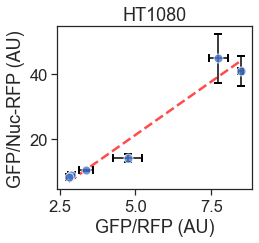

In [8]:
RFP_df = HT1080_RFP_df.loc[(HT1080_RFP_df['Elapsed'] == 27.85), ['conc_res', 'GFP_RFP_mean', 'GFP_RFP_std']]
Nuc_RFP_df = HT1080_Nuc_RFP_df.loc[(HT1080_Nuc_RFP_df['Elapsed'] == 28.5), ['conc_res', 'GFP_RFP_mean', 'GFP_RFP_std']]
comp_df = RFP_df.merge(Nuc_RFP_df, on='conc_res', suffixes=('_RFP', '_Nuc-RFP'))

fig, ax1 = plt.subplots(1, 1, figsize=(3.5, 3))
g1 = sns.regplot(ax=ax1, data=comp_df, x='GFP_RFP_mean_RFP', y='GFP_RFP_mean_Nuc-RFP', \
                 ci=False, scatter_kws=dict(alpha=0.8, linewidth=1, zorder=9, edgecolor='white', s=80), \
                 line_kws=dict(alpha=0.7, linewidth=2.5, zorder=5, color='red', ls='--'))
g1.set_ylabel('GFP/Nuc-RFP (AU)')
g1.set_xlabel('GFP/RFP (AU)')
g1.set_title('HT1080')

ax1.errorbar(x=comp_df['GFP_RFP_mean_RFP'], y=comp_df['GFP_RFP_mean_Nuc-RFP'], \
             xerr=comp_df['GFP_RFP_std_RFP'], yerr=comp_df['GFP_RFP_std_Nuc-RFP'], \
             ls='none', capsize=4, capthick=2, elinewidth=1.5, \
             color='black', zorder=6)

pdf_fnam = 'temporal_plots/HT1080_norm_comp.pdf'.format(plate_name_sele)
fig.savefig(pdf_fnam, bbox_inches='tight')

### H1299 Nuc-RFP Asp-sens Rotenone titration

IC_data/AS_P9/AS_P9_all.xlsx


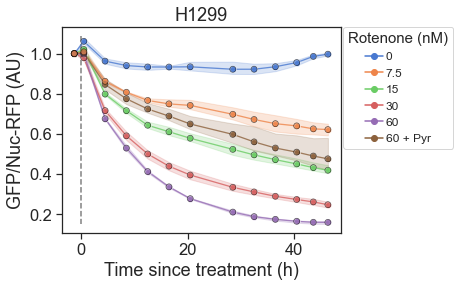

In [9]:
plate_name_sele = 'AS_P9'



row_found = False
for _, row in plate_anno.iterrows():
    if row['Plate name'] == plate_name_sele:
        row_found = True
        break
assert(row_found)
    
fnam, pnam = row['Folder name'], row['Plate name']
Nmes_pre, t_to_mes = row['Nmes pre'], row['Time to mes']

wb_name = '{}/{}/{}_all.xlsx'.format(data_folder, fnam, pnam)
sheet_name = '{}_GFP-RFP'.format(pnam)
sheet_name_rfp = '{}_RFP'.format(pnam)
print(wb_name)
#print(sheet_name)
df = pd.read_excel(wb_name, header=1, sheet_name=sheet_name)
# Fix treatment time and mask useless timepoints:
df['Elapsed'] = df['Elapsed'] - df['Elapsed'].values[Nmes_pre] + t_to_mes
time_mask = df['Elapsed'] < row['max time']
df = df[time_mask].copy()

# Find the columns for the plate:
df_melt = df.melt(['Date Time', 'Elapsed'], value_name='GFP/RFP', var_name='Well')
well_ids = natsorted(list(set(df_melt['Well'])))

# Mask timepoint with confluent cells:
df_rfp = pd.read_excel(wb_name, header=1, sheet_name=sheet_name_rfp)
df_rfp = df_rfp[time_mask].copy()
df_rfp.loc[:, well_ids] = df_rfp.loc[:, well_ids] / df_rfp.loc[0, well_ids]

cut_mask = df_rfp.loc[:, well_ids] < row['rfp fold cut']
df.loc[:, well_ids] = df.loc[:, well_ids][cut_mask].copy()


df_melt = df.melt(['Date Time', 'Elapsed'], value_name='GFP/RFP', var_name='Well')
df_melt = df_melt[~df_melt.isna()].copy()
df_norm = df.copy()
df_norm.loc[:, well_ids] = df.loc[:, well_ids] / df.loc[0, well_ids]
df_norm_melt = df_norm.melt(['Date Time', 'Elapsed'], value_name='GFP/RFP', var_name='Well')
df_norm_melt = df_norm_melt[~df_norm_melt.isna()].copy()
anno_mask = (well_anno['Folder name'] == fnam) & (well_anno['Plate name'] == pnam)
plate_data = well_anno[anno_mask].merge(df_melt, on='Well').reset_index(drop=True)
plate_data_norm = well_anno[anno_mask].merge(df_norm_melt, on='Well').reset_index(drop=True)
plate_data['GFP/RFP norm'] = plate_data_norm['GFP/RFP'].copy()
# Remove non-included wells:
plate_data = plate_data[plate_data['include']].copy()
grp_cols = list(set(plate_data.columns) - set(['GFP/RFP', 'GFP/RFP norm', 'Well']))
plate_data_avg = plate_data.groupby(grp_cols).agg(GFP_RFP_mean=('GFP/RFP', 'mean'), 
                                                  GFP_RFP_std=('GFP/RFP', 'std'), 
                                                  GFP_RFP_norm_mean=('GFP/RFP norm', 'mean'), 
                                                  GFP_RFP_norm_std=('GFP/RFP norm', 'std')).reset_index()


style = 'Drug'
markers = True
pmode = 'GFP/RFP norm'
pmode_avg = 'GFP_RFP_norm_mean'
min_sens = plate_data[pmode].min()
max_sens = plate_data[pmode].max()
hue_order = natsorted(set(plate_data['conc_res']))

fig, ax1 = plt.subplots(1, 1, figsize=(5, 3.8))
g1 = sns.lineplot(ax=ax1, data=plate_data, y=pmode, x='Elapsed', hue='conc_res', style='conc_res', \
                  zorder=9, alpha=0.8, linewidth=1.3, legend=True, \
                  errorbar=('ci', row['ci']), hue_order=hue_order, \
                  markers=["o"]*len(hue_order), dashes=[""]*len(hue_order))

g2 = sns.scatterplot(ax=ax1, data=plate_data_avg, y=pmode_avg, x='Elapsed', hue='conc_res', \
                     zorder=10, alpha=0.6, edgecolor='black', linewidth=0.7, \
                     legend=False, markers=markers, style=style, hue_order=hue_order)

g2.set_ylabel('GFP/Nuc-RFP (AU)')
g2.set_xlabel('Time since treatment (h)')
g2.set_title('H1299')
sns.move_legend(g2, "upper left", bbox_to_anchor=(1.01, 1), frameon=True, ncol=1, \
                alignment='center', labelspacing=0.5, handletextpad=0.2, borderaxespad=0, \
                handlelength=1.5, title='{} ({})'.format(row['Drug'], row['Conc unit']), \
                fontsize=12, title_fontsize=15)

ax1.vlines(0, max_sens, min_sens, ls='--', color='grey')


pdf_fnam = 'temporal_plots/{}.pdf'.format(plate_name_sele)
fig.savefig(pdf_fnam, bbox_inches='tight')

### 293t Asp-sens-RFP Rotenone titration

IC_data/AS_P12/AS_P12_all.xlsx


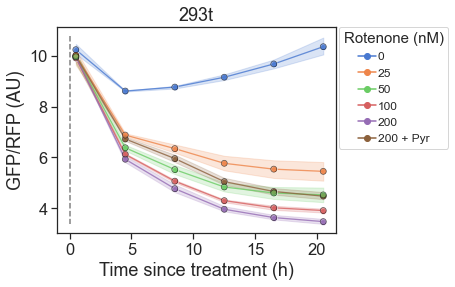

In [10]:
plate_name_sele = 'AS_P12'



row_found = False
for _, row in plate_anno.iterrows():
    if row['Plate name'] == plate_name_sele:
        row_found = True
        break
assert(row_found)
    
fnam, pnam = row['Folder name'], row['Plate name']
Nmes_pre, t_to_mes = row['Nmes pre'], row['Time to mes']

wb_name = '{}/{}/{}_all.xlsx'.format(data_folder, fnam, pnam)
sheet_name = '{}_GFP-RFP'.format(pnam)
sheet_name_rfp = '{}_RFP'.format(pnam)
print(wb_name)
#print(sheet_name)
df = pd.read_excel(wb_name, header=1, sheet_name=sheet_name)
# Fix treatment time and mask useless timepoints:
df['Elapsed'] = df['Elapsed'] - df['Elapsed'].values[Nmes_pre] + t_to_mes
time_mask = df['Elapsed'] < row['max time']
df = df[time_mask].copy()

# Find the columns for the plate:
df_melt = df.melt(['Date Time', 'Elapsed'], value_name='GFP/RFP', var_name='Well')
well_ids = natsorted(list(set(df_melt['Well'])))

# Mask timepoint with confluent cells:
df_rfp = pd.read_excel(wb_name, header=1, sheet_name=sheet_name_rfp)
df_rfp = df_rfp[time_mask].copy()
df_rfp.loc[:, well_ids] = df_rfp.loc[:, well_ids] / df_rfp.loc[0, well_ids]

cut_mask = df_rfp.loc[:, well_ids] < row['rfp fold cut']
df.loc[:, well_ids] = df.loc[:, well_ids][cut_mask].copy()


df_melt = df.melt(['Date Time', 'Elapsed'], value_name='GFP/RFP', var_name='Well')
df_melt = df_melt[~df_melt.isna()].copy()
df_norm = df.copy()
df_norm.loc[:, well_ids] = df.loc[:, well_ids] / df.loc[0, well_ids]
df_norm_melt = df_norm.melt(['Date Time', 'Elapsed'], value_name='GFP/RFP', var_name='Well')
df_norm_melt = df_norm_melt[~df_norm_melt.isna()].copy()
anno_mask = (well_anno['Folder name'] == fnam) & (well_anno['Plate name'] == pnam)
plate_data = well_anno[anno_mask].merge(df_melt, on='Well').reset_index(drop=True)
plate_data_norm = well_anno[anno_mask].merge(df_norm_melt, on='Well').reset_index(drop=True)
plate_data['GFP/RFP norm'] = plate_data_norm['GFP/RFP'].copy()
# Remove non-included wells:
plate_data = plate_data[plate_data['include']].copy()
grp_cols = list(set(plate_data.columns) - set(['GFP/RFP', 'GFP/RFP norm', 'Well']))
plate_data_avg = plate_data.groupby(grp_cols).agg(GFP_RFP_mean=('GFP/RFP', 'mean'), 
                                                  GFP_RFP_std=('GFP/RFP', 'std'), 
                                                  GFP_RFP_norm_mean=('GFP/RFP norm', 'mean'), 
                                                  GFP_RFP_norm_std=('GFP/RFP norm', 'std')).reset_index()


style = 'Drug'
markers = True
pmode = 'GFP/RFP'
pmode_avg = 'GFP_RFP_mean'
min_sens = plate_data[pmode].min()
max_sens = plate_data[pmode].max()
hue_order = natsorted(set(plate_data['conc_res']))

fig, ax1 = plt.subplots(1, 1, figsize=(5, 3.8))
g1 = sns.lineplot(ax=ax1, data=plate_data, y=pmode, x='Elapsed', hue='conc_res', style='conc_res', \
                  zorder=9, alpha=0.8, linewidth=1.3, legend=True, \
                  errorbar=('ci', row['ci']), hue_order=hue_order, \
                  markers=["o"]*len(hue_order), dashes=[""]*len(hue_order))

g2 = sns.scatterplot(ax=ax1, data=plate_data_avg, y=pmode_avg, x='Elapsed', hue='conc_res', \
                     zorder=10, alpha=0.6, edgecolor='black', linewidth=0.7, \
                     legend=False, markers=markers, style=style, hue_order=hue_order)

g2.set_ylabel('GFP/RFP (AU)')
g2.set_xlabel('Time since treatment (h)')
g2.set_title('293t')
sns.move_legend(g2, "upper left", bbox_to_anchor=(1.01, 1), frameon=True, ncol=1, \
                alignment='center', labelspacing=0.5, handletextpad=0.2, borderaxespad=0, \
                handlelength=1.5, title='{} ({})'.format(row['Drug'], row['Conc unit']), \
                fontsize=12, title_fontsize=15)

ax1.vlines(0, max_sens, min_sens, ls='--', color='grey')


pdf_fnam = 'temporal_plots/{}.pdf'.format(plate_name_sele)
fig.savefig(pdf_fnam, bbox_inches='tight')

### H1299 Nuc-RFP Asp-sens Rotenone vs. Metformin reponse time

IC_data/AS_P22/AS_P22_all.xlsx


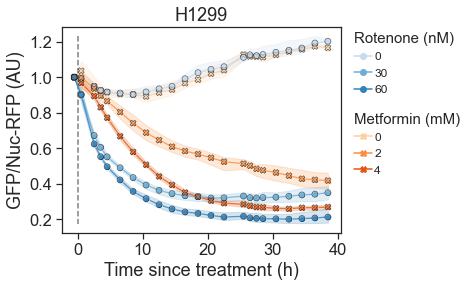

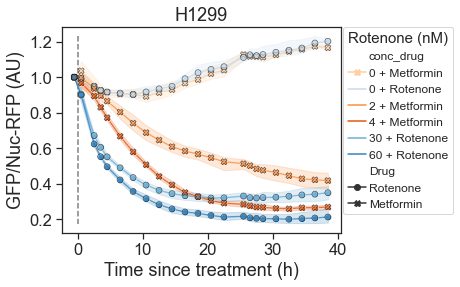

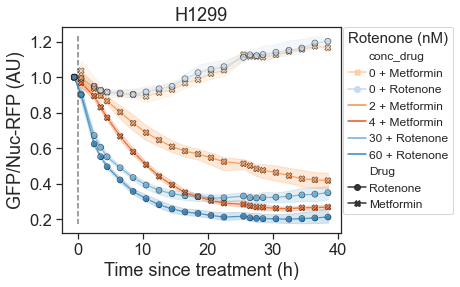

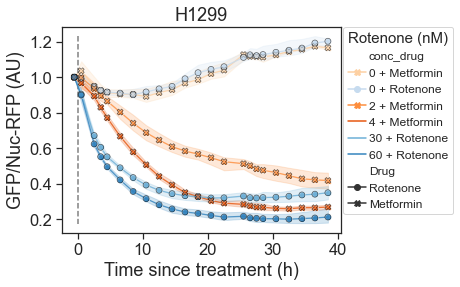

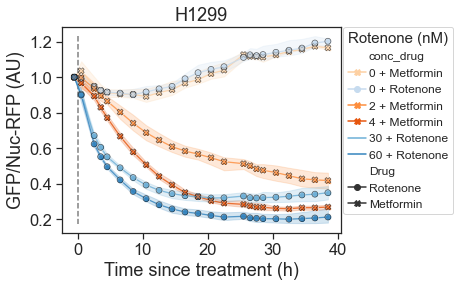

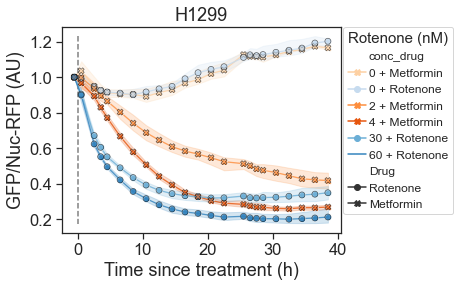

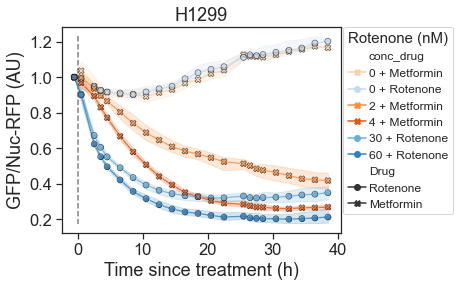

In [11]:
plate_name_sele = 'AS_P22'



row_found = False
for _, row in plate_anno.iterrows():
    if row['Plate name'] == plate_name_sele:
        row_found = True
        break
assert(row_found)
    
fnam, pnam = row['Folder name'], row['Plate name']
Nmes_pre, t_to_mes = row['Nmes pre'], row['Time to mes']

wb_name = '{}/{}/{}_all.xlsx'.format(data_folder, fnam, pnam)
sheet_name = '{}_GFP-RFP'.format(pnam)
sheet_name_rfp = '{}_RFP'.format(pnam)
print(wb_name)
#print(sheet_name)
df = pd.read_excel(wb_name, header=1, sheet_name=sheet_name)
# Fix treatment time and mask useless timepoints:
df['Elapsed'] = df['Elapsed'] - df['Elapsed'].values[Nmes_pre] + t_to_mes
time_mask = df['Elapsed'] < row['max time']
df = df[time_mask].copy()

# Find the columns for the plate:
df_melt = df.melt(['Date Time', 'Elapsed'], value_name='GFP/RFP', var_name='Well')
well_ids = natsorted(list(set(df_melt['Well'])))

# Mask timepoint with confluent cells:
df_rfp = pd.read_excel(wb_name, header=1, sheet_name=sheet_name_rfp)
df_rfp = df_rfp[time_mask].copy()
df_rfp.loc[:, well_ids] = df_rfp.loc[:, well_ids] / df_rfp.loc[0, well_ids]

cut_mask = df_rfp.loc[:, well_ids] < row['rfp fold cut']
df.loc[:, well_ids] = df.loc[:, well_ids][cut_mask].copy()


df_melt = df.melt(['Date Time', 'Elapsed'], value_name='GFP/RFP', var_name='Well')
df_melt = df_melt[~df_melt.isna()].copy()
df_norm = df.copy()
df_norm.loc[:, well_ids] = df.loc[:, well_ids] / df.loc[0, well_ids]
df_norm_melt = df_norm.melt(['Date Time', 'Elapsed'], value_name='GFP/RFP', var_name='Well')
df_norm_melt = df_norm_melt[~df_norm_melt.isna()].copy()
anno_mask = (well_anno['Folder name'] == fnam) & (well_anno['Plate name'] == pnam)
plate_data = well_anno[anno_mask].merge(df_melt, on='Well').reset_index(drop=True)
plate_data_norm = well_anno[anno_mask].merge(df_norm_melt, on='Well').reset_index(drop=True)
plate_data['GFP/RFP norm'] = plate_data_norm['GFP/RFP'].copy()
# Remove non-included wells:
plate_data = plate_data[plate_data['include']].copy()
grp_cols = list(set(plate_data.columns) - set(['GFP/RFP', 'GFP/RFP norm', 'Well']))
plate_data_avg = plate_data.groupby(grp_cols).agg(GFP_RFP_mean=('GFP/RFP', 'mean'), 
                                                  GFP_RFP_std=('GFP/RFP', 'std'), 
                                                  GFP_RFP_norm_mean=('GFP/RFP norm', 'mean'), 
                                                  GFP_RFP_norm_std=('GFP/RFP norm', 'std')).reset_index()


style = 'Drug'
style_order = ['Rotenone', 'Metformin']
markers = True
pmode = 'GFP/RFP norm'
pmode_avg = 'GFP_RFP_norm_mean'
min_sens = plate_data[pmode].min()
max_sens = plate_data[pmode].max()
hue_order = natsorted(set(plate_data['conc_drug']))

pal = sns.color_palette('tab20c')
pal2 = sns.color_palette(palette=[pal[7], pal[3], pal[5], pal[4], pal[1], pal[0]])

fig, ax1 = plt.subplots(1, 1, figsize=(5, 3.8))
g1 = sns.lineplot(ax=ax1, data=plate_data, y=pmode, x='Elapsed', hue='conc_drug', style='Drug', \
                  zorder=9, alpha=0.8, linewidth=1.3, legend=True, \
                  errorbar=('ci', row['ci']), hue_order=hue_order, style_order=style_order, \
                  markers=True, dashes=[""]*len(style_order), \
                  palette=pal2);

g2 = sns.scatterplot(ax=ax1, data=plate_data_avg, y=pmode_avg, x='Elapsed', hue='conc_drug', \
                     zorder=10, alpha=0.6, edgecolor='black', linewidth=0.7, \
                     legend=False, markers=markers, style=style, \
                     hue_order=hue_order, style_order=style_order, \
                     palette=pal2);

g2.set_ylabel('GFP/Nuc-RFP (AU)');
g2.set_xlabel('Time since treatment (h)');
g2.set_title('H1299');
sns.move_legend(g2, "upper left", bbox_to_anchor=(1.01, 1), frameon=True, ncol=1, \
                alignment='center', labelspacing=0.5, handletextpad=0.2, borderaxespad=0, \
                handlelength=1.5, title='{} ({})'.format(row['Drug'], row['Conc unit']), \
                fontsize=12, title_fontsize=15);

ax1.vlines(0, max_sens, min_sens, ls='--', color='grey');


rot_lh, rot_lt = [], []
met_lh, met_lt = [], []
for lh in ax1.legend_.legendHandles:
    l_txt = lh.get_label().split(' + ')
    if len(l_txt) == 1:
        continue
    if 'Rotenone' in l_txt[1]:
        lh.set_marker('o')
        rot_lh.append(copy.deepcopy(lh))
        rot_lt.append(l_txt[0])
    elif 'Metformin' in l_txt[1]:
        lh.set_marker('X')
        met_lh.append(copy.deepcopy(lh))
        met_lt.append(l_txt[0])

l1 = ax1.legend(rot_lh, rot_lt, loc='upper left', bbox_to_anchor=(1.03, 1), frameon=False, ncol=1, \
                alignment='left', labelspacing=0.5, handletextpad=0.2, borderaxespad=0, \
                handlelength=1.5, title='Rotenone (nM)', fontsize=12, title_fontsize=15)
l2 = ax1.legend(met_lh, met_lt, loc='upper left', bbox_to_anchor=(1.03, 0.61), frameon=False, ncol=1, \
                alignment='left', labelspacing=0.5, handletextpad=0.2, borderaxespad=0, \
                handlelength=1.5, title='Metformin (mM)', fontsize=12, title_fontsize=15)
ax1.add_artist(l1)


pdf_fnam = 'temporal_plots/{}.pdf'.format(plate_name_sele)
fig.savefig(pdf_fnam, bbox_inches='tight')

### H1299 GOT-DKO Nuc-RFP Asp-sens media aspartate titration

IC_data/AS_P6/AS_P6_all.xlsx


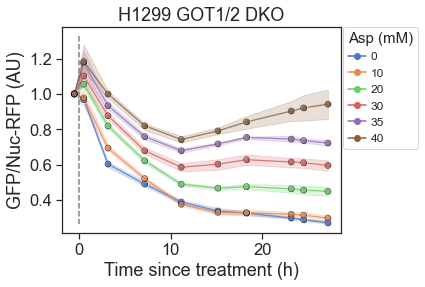

In [12]:
plate_name_sele = 'AS_P6'



row_found = False
for _, row in plate_anno.iterrows():
    if row['Plate name'] == plate_name_sele:
        row_found = True
        break
assert(row_found)
    
fnam, pnam = row['Folder name'], row['Plate name']
Nmes_pre, t_to_mes = row['Nmes pre'], row['Time to mes']

wb_name = '{}/{}/{}_all.xlsx'.format(data_folder, fnam, pnam)
sheet_name = '{}_GFP-RFP'.format(pnam)
sheet_name_rfp = '{}_RFP'.format(pnam)
print(wb_name)
#print(sheet_name)
df = pd.read_excel(wb_name, header=1, sheet_name=sheet_name)
# Fix treatment time and mask useless timepoints:
df['Elapsed'] = df['Elapsed'] - df['Elapsed'].values[Nmes_pre] + t_to_mes
time_mask = df['Elapsed'] < row['max time']
df = df[time_mask].copy()

# Find the columns for the plate:
df_melt = df.melt(['Date Time', 'Elapsed'], value_name='GFP/RFP', var_name='Well')
well_ids = natsorted(list(set(df_melt['Well'])))

# Mask timepoint with confluent cells:
df_rfp = pd.read_excel(wb_name, header=1, sheet_name=sheet_name_rfp)
df_rfp = df_rfp[time_mask].copy()
df_rfp.loc[:, well_ids] = df_rfp.loc[:, well_ids] / df_rfp.loc[0, well_ids]

cut_mask = df_rfp.loc[:, well_ids] < row['rfp fold cut']
df.loc[:, well_ids] = df.loc[:, well_ids][cut_mask].copy()


df_melt = df.melt(['Date Time', 'Elapsed'], value_name='GFP/RFP', var_name='Well')
df_melt = df_melt[~df_melt.isna()].copy()
df_norm = df.copy()
df_norm.loc[:, well_ids] = df.loc[:, well_ids] / df.loc[0, well_ids]
df_norm_melt = df_norm.melt(['Date Time', 'Elapsed'], value_name='GFP/RFP', var_name='Well')
df_norm_melt = df_norm_melt[~df_norm_melt.isna()].copy()
anno_mask = (well_anno['Folder name'] == fnam) & (well_anno['Plate name'] == pnam)
plate_data = well_anno[anno_mask].merge(df_melt, on='Well').reset_index(drop=True)
plate_data_norm = well_anno[anno_mask].merge(df_norm_melt, on='Well').reset_index(drop=True)
plate_data['GFP/RFP norm'] = plate_data_norm['GFP/RFP'].copy()
# Remove non-included wells:
plate_data = plate_data[plate_data['include']].copy()
grp_cols = list(set(plate_data.columns) - set(['GFP/RFP', 'GFP/RFP norm', 'Well']))
plate_data_avg = plate_data.groupby(grp_cols).agg(GFP_RFP_mean=('GFP/RFP', 'mean'), 
                                                  GFP_RFP_std=('GFP/RFP', 'std'), 
                                                  GFP_RFP_norm_mean=('GFP/RFP norm', 'mean'), 
                                                  GFP_RFP_norm_std=('GFP/RFP norm', 'std')).reset_index()


style = 'Drug'
markers = True
pmode = 'GFP/RFP norm'
pmode_avg = 'GFP_RFP_norm_mean'
min_sens = plate_data[pmode].min()
max_sens = plate_data[pmode].max()
hue_order = natsorted(set(plate_data['conc_res']))

fig, ax1 = plt.subplots(1, 1, figsize=(5, 3.8))
g1 = sns.lineplot(ax=ax1, data=plate_data, y=pmode, x='Elapsed', hue='conc_res', style='conc_res', \
                  zorder=9, alpha=0.8, linewidth=1.3, legend=True, \
                  errorbar=('ci', row['ci']), hue_order=hue_order, \
                  markers=["o"]*len(hue_order), dashes=[""]*len(hue_order))

g2 = sns.scatterplot(ax=ax1, data=plate_data_avg, y=pmode_avg, x='Elapsed', hue='conc_res', \
                     zorder=10, alpha=0.6, edgecolor='black', linewidth=0.7, \
                     legend=False, markers=markers, style=style, hue_order=hue_order)

g2.set_ylabel('GFP/Nuc-RFP (AU)')
g2.set_xlabel('Time since treatment (h)')
g2.set_title('H1299 GOT1/2 DKO')
sns.move_legend(g2, "upper left", bbox_to_anchor=(1.01, 1), frameon=True, ncol=1, \
                alignment='left', labelspacing=0.5, handletextpad=0.4, borderaxespad=0, \
                handlelength=1.5, title='Asp (mM)', fontsize=12, title_fontsize=15)

ax1.vlines(0, max_sens, min_sens, ls='--', color='grey')


pdf_fnam = 'temporal_plots/{}.pdf'.format(plate_name_sele)
fig.savefig(pdf_fnam, bbox_inches='tight')

### H1299 Nuc-RFP Asp-sens glutamine titration w/wo asparagine

IC_data/AS_P13/AS_P13_all.xlsx


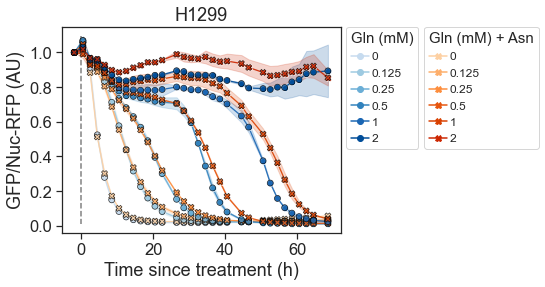

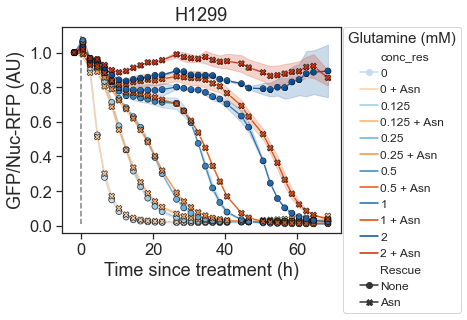

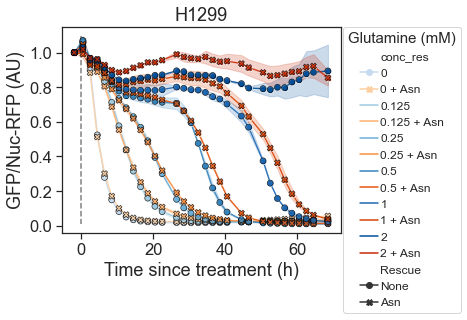

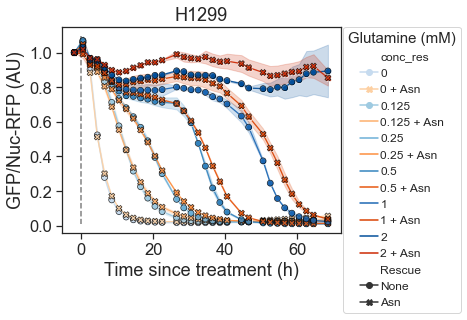

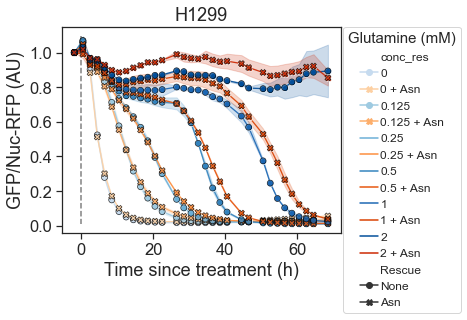

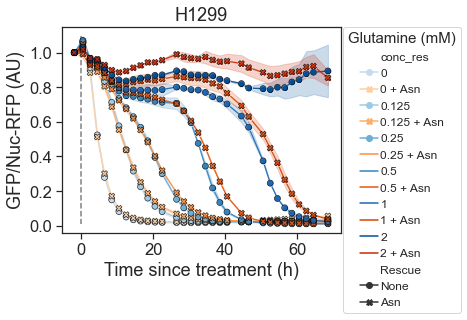

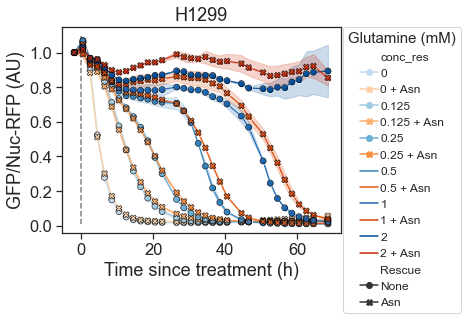

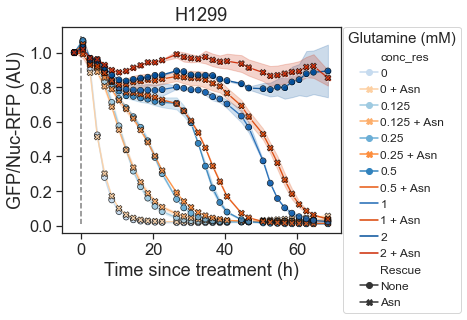

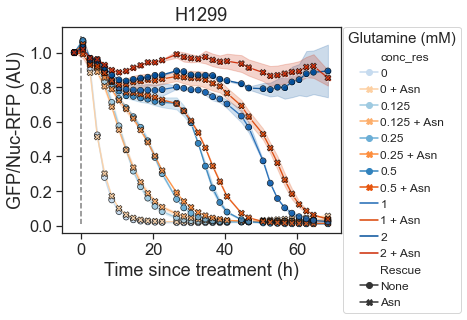

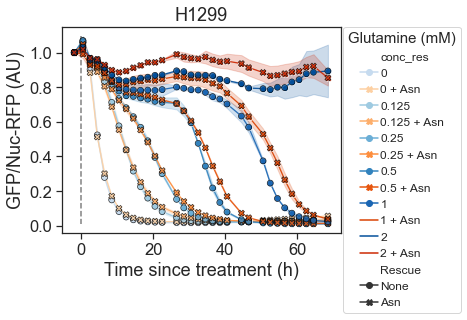

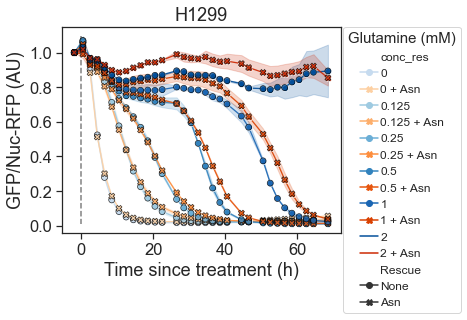

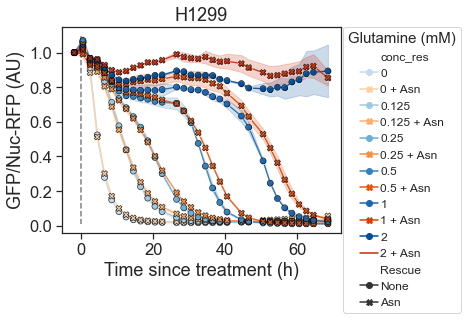

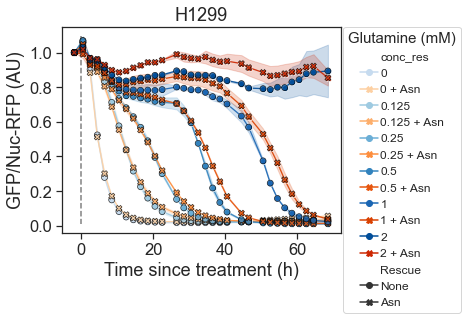

In [13]:
plate_name_sele = 'AS_P13'



row_found = False
for _, row in plate_anno.iterrows():
    if row['Plate name'] == plate_name_sele:
        row_found = True
        break
assert(row_found)
    
fnam, pnam = row['Folder name'], row['Plate name']
Nmes_pre, t_to_mes = row['Nmes pre'], row['Time to mes']

wb_name = '{}/{}/{}_all.xlsx'.format(data_folder, fnam, pnam)
sheet_name = '{}_GFP-RFP'.format(pnam)
sheet_name_rfp = '{}_RFP'.format(pnam)
print(wb_name)
#print(sheet_name)
df = pd.read_excel(wb_name, header=1, sheet_name=sheet_name)
# Fix treatment time and mask useless timepoints:
df['Elapsed'] = df['Elapsed'] - df['Elapsed'].values[Nmes_pre] + t_to_mes
time_mask = df['Elapsed'] < row['max time']
df = df[time_mask].copy()

# Find the columns for the plate:
df_melt = df.melt(['Date Time', 'Elapsed'], value_name='GFP/RFP', var_name='Well')
well_ids = natsorted(list(set(df_melt['Well'])))

# Mask timepoint with confluent cells:
df_rfp = pd.read_excel(wb_name, header=1, sheet_name=sheet_name_rfp)
df_rfp = df_rfp[time_mask].copy()
df_rfp.loc[:, well_ids] = df_rfp.loc[:, well_ids] / df_rfp.loc[0, well_ids]

cut_mask = df_rfp.loc[:, well_ids] < row['rfp fold cut']
df.loc[:, well_ids] = df.loc[:, well_ids][cut_mask].copy()


df_melt = df.melt(['Date Time', 'Elapsed'], value_name='GFP/RFP', var_name='Well')
df_melt = df_melt[~df_melt.isna()].copy()
df_norm = df.copy()
df_norm.loc[:, well_ids] = df.loc[:, well_ids] / df.loc[0, well_ids]
df_norm_melt = df_norm.melt(['Date Time', 'Elapsed'], value_name='GFP/RFP', var_name='Well')
df_norm_melt = df_norm_melt[~df_norm_melt.isna()].copy()
anno_mask = (well_anno['Folder name'] == fnam) & (well_anno['Plate name'] == pnam)
plate_data = well_anno[anno_mask].merge(df_melt, on='Well').reset_index(drop=True)
plate_data_norm = well_anno[anno_mask].merge(df_norm_melt, on='Well').reset_index(drop=True)
plate_data['GFP/RFP norm'] = plate_data_norm['GFP/RFP'].copy()
# Remove non-included wells:
plate_data = plate_data[plate_data['include']].copy()
grp_cols = list(set(plate_data.columns) - set(['GFP/RFP', 'GFP/RFP norm', 'Well']))
plate_data_avg = plate_data.groupby(grp_cols).agg(GFP_RFP_mean=('GFP/RFP', 'mean'), 
                                                  GFP_RFP_std=('GFP/RFP', 'std'), 
                                                  GFP_RFP_norm_mean=('GFP/RFP norm', 'mean'), 
                                                  GFP_RFP_norm_std=('GFP/RFP norm', 'std')).reset_index()

style_order = ['None', 'Asn']
style = 'Rescue'
markers = True
pmode = 'GFP/RFP norm'
pmode_avg = 'GFP_RFP_norm_mean'
min_sens = plate_data[pmode].min()
max_sens = plate_data[pmode].max()
hue_order = sorted(set(plate_data['conc_res']))

pal = sns.color_palette('tab20c')
pal2 = sns.color_palette(palette=[c for t in zip([*pal[0:4][::-1], (0.1, 0.4, 0.7), (0, 0.3, 0.6)], [*pal[4:8][::-1], (0.85, 0.25, 0), (0.8, 0.15, 0)]) for c in t])

fig, ax1 = plt.subplots(1, 1, figsize=(5, 3.8))
g1 = sns.lineplot(ax=ax1, data=plate_data, y=pmode, x='Elapsed', hue='conc_res', style='Rescue', \
                  zorder=9, alpha=0.9, linewidth=1.3, legend=True, \
                  errorbar=('ci', row['ci']), hue_order=hue_order, \
                  markers=True, dashes=[""]*len(style_order), style_order=style_order, \
                  palette=pal2);

g2 = sns.scatterplot(ax=ax1, data=plate_data_avg, y=pmode_avg, x='Elapsed', hue='conc_res', \
                     zorder=10, alpha=0.8, edgecolor='black', linewidth=0.7, \
                     legend=False, markers=markers, style=style, style_order=style_order, \
                     hue_order=hue_order, \
                     palette=pal2);

g2.set_ylabel('GFP/Nuc-RFP (AU)');
g2.set_xlabel('Time since treatment (h)');
g2.set_title('H1299');
sns.move_legend(g2, "upper left", bbox_to_anchor=(1.01, 1), frameon=True, ncol=1, \
                alignment='center', labelspacing=0.5, handletextpad=0.2, borderaxespad=0, \
                handlelength=1.5, title='{} ({})'.format(row['Drug'], row['Conc unit']), \
                fontsize=12, title_fontsize=15);

ax1.vlines(0, max_sens, min_sens, ls='--', color='grey');


none_lh, none_lt = [], []
asn_lh, asn_lt = [], []
for lh in ax1.legend_.legendHandles:
    l_txt = lh.get_label()
    if 'Asn' in l_txt:
        l_txt = l_txt.split(' + ')
        if len(l_txt) == 1:
            continue
        lh.set_marker('X');
        asn_lh.append(copy.deepcopy(lh))
        asn_lt.append(l_txt[0])
    else:
        try:
            float(l_txt)
        except:
            continue
        lh.set_marker('o');
        none_lh.append(copy.deepcopy(lh))
        none_lt.append(l_txt)

l1 = ax1.legend(none_lh, none_lt, loc='upper left', bbox_to_anchor=(1.02, 1), frameon=True, ncol=1, \
                alignment='left', labelspacing=0.5, handletextpad=0.2, borderaxespad=0, \
                handlelength=1.5, title='Gln (mM)', fontsize=12, title_fontsize=15)
l2 = ax1.legend(asn_lh, asn_lt, loc='upper left', bbox_to_anchor=(1.3, 1), frameon=True, ncol=1, \
                alignment='left', labelspacing=0.5, handletextpad=0.2, borderaxespad=0, \
                handlelength=1.5, title='Gln (mM) + Asn', fontsize=12, title_fontsize=15)
ax1.add_artist(l1)


pdf_fnam = 'temporal_plots/{}.pdf'.format(plate_name_sele)
fig.savefig(pdf_fnam, bbox_inches='tight')

### H1299 Nuc-RFP Asp-sens glutamine titration w/wo asparagine - narrow range

IC_data/AS_P25/AS_P25_all.xlsx


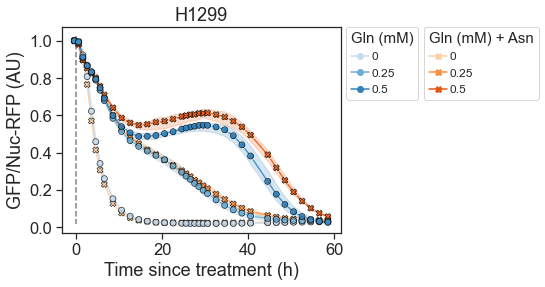

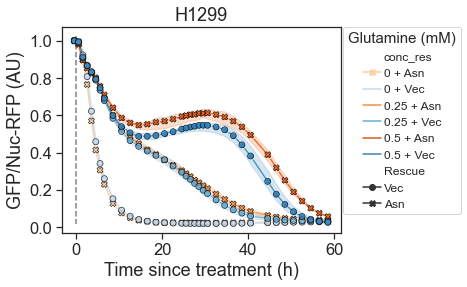

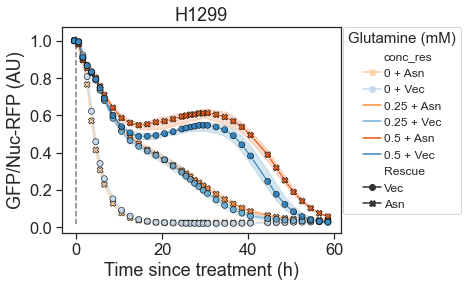

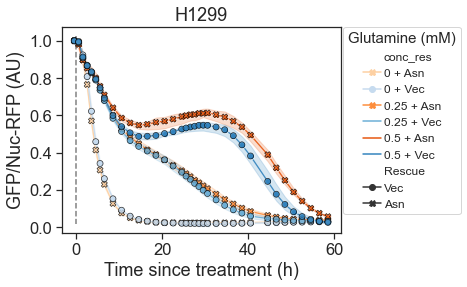

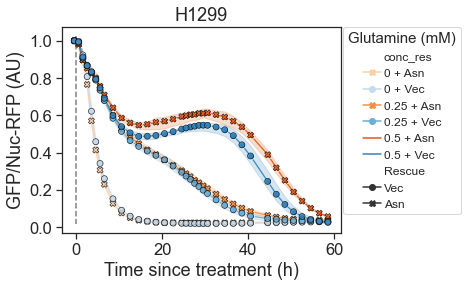

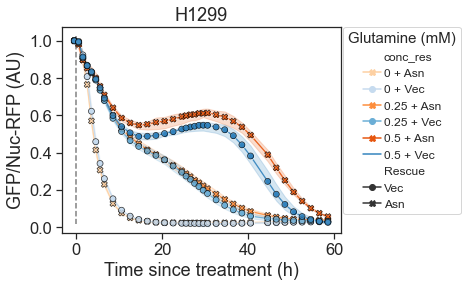

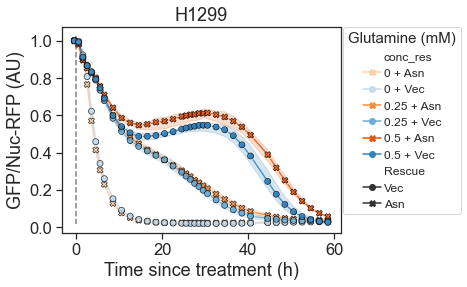

In [6]:
plate_name_sele = 'AS_P25'



row_found = False
for _, row in plate_anno.iterrows():
    if row['Plate name'] == plate_name_sele:
        row_found = True
        break
assert(row_found)
    
fnam, pnam = row['Folder name'], row['Plate name']
Nmes_pre, t_to_mes = row['Nmes pre'], row['Time to mes']

wb_name = '{}/{}/{}_all.xlsx'.format(data_folder, fnam, pnam)
sheet_name = '{}_GFP-RFP'.format(pnam)
sheet_name_rfp = '{}_RFP'.format(pnam)
print(wb_name)
#print(sheet_name)
df = pd.read_excel(wb_name, header=1, sheet_name=sheet_name)
# Fix treatment time and mask useless timepoints:
df['Elapsed'] = df['Elapsed'] - df['Elapsed'].values[Nmes_pre] + t_to_mes
time_mask = df['Elapsed'] < row['max time']
df = df[time_mask].copy()

# Find the columns for the plate:
df_melt = df.melt(['Date Time', 'Elapsed'], value_name='GFP/RFP', var_name='Well')
well_ids = natsorted(list(set(df_melt['Well'])))

# Mask timepoint with confluent cells:
df_rfp = pd.read_excel(wb_name, header=1, sheet_name=sheet_name_rfp)
df_rfp = df_rfp[time_mask].copy()
df_rfp.loc[:, well_ids] = df_rfp.loc[:, well_ids] / df_rfp.loc[0, well_ids]

cut_mask = df_rfp.loc[:, well_ids] < row['rfp fold cut']
df.loc[:, well_ids] = df.loc[:, well_ids][cut_mask].copy()


df_melt = df.melt(['Date Time', 'Elapsed'], value_name='GFP/RFP', var_name='Well')
df_melt = df_melt[~df_melt.isna()].copy()
df_norm = df.copy()
df_norm.loc[:, well_ids] = df.loc[:, well_ids] / df.loc[0, well_ids]
df_norm_melt = df_norm.melt(['Date Time', 'Elapsed'], value_name='GFP/RFP', var_name='Well')
df_norm_melt = df_norm_melt[~df_norm_melt.isna()].copy()
anno_mask = (well_anno['Folder name'] == fnam) & (well_anno['Plate name'] == pnam)
plate_data = well_anno[anno_mask].merge(df_melt, on='Well').reset_index(drop=True)
plate_data_norm = well_anno[anno_mask].merge(df_norm_melt, on='Well').reset_index(drop=True)
plate_data['GFP/RFP norm'] = plate_data_norm['GFP/RFP'].copy()
# Remove non-included wells:
plate_data = plate_data[plate_data['include']].copy()
grp_cols = list(set(plate_data.columns) - set(['GFP/RFP', 'GFP/RFP norm', 'Well']))
plate_data_avg = plate_data.groupby(grp_cols).agg(GFP_RFP_mean=('GFP/RFP', 'mean'), 
                                                  GFP_RFP_std=('GFP/RFP', 'std'), 
                                                  GFP_RFP_norm_mean=('GFP/RFP norm', 'mean'), 
                                                  GFP_RFP_norm_std=('GFP/RFP norm', 'std')).reset_index()

style_order = ['Vec', 'Asn']
style = 'Rescue'
markers = True
pmode = 'GFP/RFP norm'
pmode_avg = 'GFP_RFP_norm_mean'
min_sens = plate_data[pmode].min()
max_sens = plate_data[pmode].max()
hue_order = sorted(set(plate_data['conc_res']))

pal = sns.color_palette('tab20c')
pal2 = sns.color_palette(palette=[pal[7], pal[3], pal[5], pal[1], pal[4], pal[0]])

fig, ax1 = plt.subplots(1, 1, figsize=(5, 3.8))
g1 = sns.lineplot(ax=ax1, data=plate_data, y=pmode, x='Elapsed', hue='conc_res', style='Rescue', \
                  zorder=9, alpha=0.9, linewidth=1.3, legend=True, \
                  errorbar=('ci', row['ci']), hue_order=hue_order, \
                  markers=True, dashes=[""]*len(style_order), style_order=style_order, \
                  palette=pal2);

g2 = sns.scatterplot(ax=ax1, data=plate_data_avg, y=pmode_avg, x='Elapsed', hue='conc_res', \
                     zorder=10, alpha=0.8, edgecolor='black', linewidth=0.7, \
                     legend=False, markers=markers, style=style, style_order=style_order, \
                     hue_order=hue_order, \
                     palette=pal2);

g2.set_ylabel('GFP/Nuc-RFP (AU)');
g2.set_xlabel('Time since treatment (h)');
g2.set_title('H1299');
sns.move_legend(g2, "upper left", bbox_to_anchor=(1.01, 1), frameon=True, ncol=1, \
                alignment='center', labelspacing=0.5, handletextpad=0.2, borderaxespad=0, \
                handlelength=1.5, title='{} ({})'.format(row['Drug'], row['Conc unit']), \
                fontsize=12, title_fontsize=15);

ax1.vlines(0, max_sens, min_sens, ls='--', color='grey');


none_lh, none_lt = [], []
asn_lh, asn_lt = [], []
for lh in ax1.legend_.legendHandles:
    l_txt = lh.get_label()
    if 'Asn' in l_txt:
        l_txt = l_txt.split(' + ')
        if len(l_txt) == 1:
            continue
        lh.set_marker('X');
        asn_lh.append(copy.deepcopy(lh))
        asn_lt.append(l_txt[0])
    elif 'Vec' in l_txt:
        l_txt = l_txt.split(' + ')
        if len(l_txt) == 1:
            continue
        lh.set_marker('o');
        none_lh.append(copy.deepcopy(lh))
        none_lt.append(l_txt[0])

l1 = ax1.legend(none_lh, none_lt, loc='upper left', bbox_to_anchor=(1.02, 1), frameon=True, ncol=1, \
                alignment='left', labelspacing=0.5, handletextpad=0.2, borderaxespad=0, \
                handlelength=1.5, title='Gln (mM)', fontsize=12, title_fontsize=15)
l2 = ax1.legend(asn_lh, asn_lt, loc='upper left', bbox_to_anchor=(1.3, 1), frameon=True, ncol=1, \
                alignment='left', labelspacing=0.5, handletextpad=0.2, borderaxespad=0, \
                handlelength=1.5, title='Gln (mM) + Asn', fontsize=12, title_fontsize=15)
ax1.add_artist(l1)


pdf_fnam = 'temporal_plots/{}.pdf'.format(plate_name_sele)
fig.savefig(pdf_fnam, bbox_inches='tight')

### H1299 Nuc-RFP Asp-sens glutamine depletion-repletion

IC_data/AS_P26/AS_P26_all.xlsx


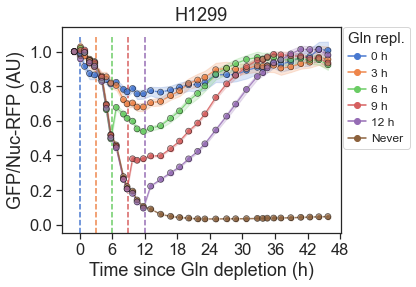

In [6]:
plate_name_sele = 'AS_P26'


row_found = False
for _, row in plate_anno.iterrows():
    if row['Plate name'] == plate_name_sele:
        row_found = True
        break
assert(row_found)
    
fnam, pnam = row['Folder name'], row['Plate name']
Nmes_pre, t_to_mes = row['Nmes pre'], row['Time to mes']

wb_name = '{}/{}/{}_all.xlsx'.format(data_folder, fnam, pnam)
sheet_name = '{}_GFP-RFP'.format(pnam)
sheet_name_rfp = '{}_RFP'.format(pnam)
print(wb_name)
#print(sheet_name)
df = pd.read_excel(wb_name, header=1, sheet_name=sheet_name)
# Fix treatment time and mask useless timepoints:
df['Elapsed'] = df['Elapsed'] - df['Elapsed'].values[Nmes_pre] + t_to_mes
time_mask = df['Elapsed'] < row['max time']
df = df[time_mask].copy()

# Find the columns for the plate:
df_melt = df.melt(['Date Time', 'Elapsed'], value_name='GFP/RFP', var_name='Well')
well_ids = natsorted(list(set(df_melt['Well'])))

# Mask timepoint with confluent cells:
df_rfp = pd.read_excel(wb_name, header=1, sheet_name=sheet_name_rfp)
df_rfp = df_rfp[time_mask].copy()
df_rfp.loc[:, well_ids] = df_rfp.loc[:, well_ids] / df_rfp.loc[0, well_ids]

cut_mask = df_rfp.loc[:, well_ids] < row['rfp fold cut']
df.loc[:, well_ids] = df.loc[:, well_ids][cut_mask].copy()


df_melt = df.melt(['Date Time', 'Elapsed'], value_name='GFP/RFP', var_name='Well')
df_melt = df_melt[~df_melt.isna()].copy()
df_norm = df.copy()
df_norm.loc[:, well_ids] = df.loc[:, well_ids] / df.loc[0, well_ids]
df_norm_melt = df_norm.melt(['Date Time', 'Elapsed'], value_name='GFP/RFP', var_name='Well')
df_norm_melt = df_norm_melt[~df_norm_melt.isna()].copy()
anno_mask = (well_anno['Folder name'] == fnam) & (well_anno['Plate name'] == pnam)
plate_data = well_anno[anno_mask].merge(df_melt, on='Well').reset_index(drop=True)
plate_data_norm = well_anno[anno_mask].merge(df_norm_melt, on='Well').reset_index(drop=True)
plate_data['GFP/RFP norm'] = plate_data_norm['GFP/RFP'].copy()
# Remove non-included wells:
plate_data = plate_data[plate_data['include']].copy()
grp_cols = list(set(plate_data.columns) - set(['GFP/RFP', 'GFP/RFP norm', 'Well']))
plate_data_avg = plate_data.groupby(grp_cols).agg(GFP_RFP_mean=('GFP/RFP', 'mean'), 
                                                  GFP_RFP_std=('GFP/RFP', 'std'), 
                                                  GFP_RFP_norm_mean=('GFP/RFP norm', 'mean'), 
                                                  GFP_RFP_norm_std=('GFP/RFP norm', 'std')).reset_index()


style = 'Drug'
markers = True
pmode = 'GFP/RFP norm'
pmode_avg = 'GFP_RFP_norm_mean'
min_sens = plate_data[pmode].min()
max_sens = plate_data[pmode].max()
hue_order = natsorted(set(plate_data['conc_time']))
hue_order.append(hue_order.pop(0))
hue_order_lab = ['0 h', '3 h', '6 h', '9 h', '12 h', 'Never']
h2l = {k:v for k, v in zip(hue_order, hue_order_lab)}
plate_data['legend_lab'] = [h2l[ct] for ct in plate_data['conc_time']]
plate_data_avg['legend_lab'] = [h2l[ct] for ct in plate_data_avg['conc_time']]


fig, ax1 = plt.subplots(1, 1, figsize=(5, 3.8))
g1 = sns.lineplot(ax=ax1, data=plate_data, y=pmode, x='Elapsed', hue='legend_lab', style='legend_lab', \
                  zorder=9, alpha=0.8, linewidth=1.3, legend=True, \
                  errorbar=('ci', row['ci']), hue_order=hue_order_lab, \
                  markers=["o"]*len(hue_order), dashes=[""]*len(hue_order))

g2 = sns.scatterplot(ax=ax1, data=plate_data_avg, y=pmode_avg, x='Elapsed', hue='legend_lab', \
                     zorder=10, alpha=0.6, edgecolor='black', linewidth=0.7, \
                     legend=False, markers=markers, style=style, hue_order=hue_order_lab)

g2.set_ylabel('GFP/Nuc-RFP (AU)')
g2.set_xlabel('Time since Gln depletion (h)')
g2.set_title('H1299')


sns.move_legend(g2, "upper left", bbox_to_anchor=(1.01, 1), frameon=True, ncol=1, \
                alignment='left', labelspacing=0.5, handletextpad=0.4, borderaxespad=0, \
                handlelength=1.5, title='Gln repl.', fontsize=12, title_fontsize=15)


cmap = sns.color_palette()
for dt, col in zip([0, 3, 6, 9, 12], list(cmap)):
    #ax1.vlines(dt, max_sens, -0.1, ls='--', color='grey')
    ax1.vlines(dt, max_sens, -0.1, ls='--', color=col)
g2.set_ylim(-0.05, g2.get_ylim()[1])
# g2.set_xticks([0, 5, 10, 15, 20, 25, 30, 35, 40, 45])
#g2.set_xticks([0, 10, 20, 30, 40])
g2.set_xticks([0, 6, 12, 18, 24, 30, 36, 42, 48])

pdf_fnam = 'temporal_plots/{}.pdf'.format(plate_name_sele)
fig.savefig(pdf_fnam, bbox_inches='tight')

IC_data/AS_P26/AS_P26_all.xlsx


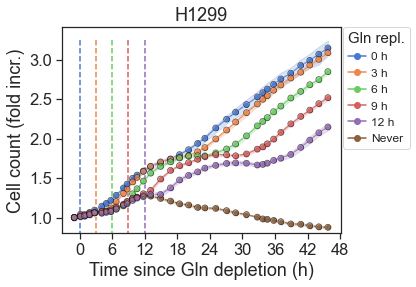

In [13]:
plate_name_sele = 'AS_P26'


row_found = False
for _, row in plate_anno.iterrows():
    if row['Plate name'] == plate_name_sele:
        row_found = True
        break
assert(row_found)
    
fnam, pnam = row['Folder name'], row['Plate name']
Nmes_pre, t_to_mes = row['Nmes pre'], row['Time to mes']

wb_name = '{}/{}/{}_all.xlsx'.format(data_folder, fnam, pnam)
sheet_name = '{}_count'.format(pnam)
print(wb_name)
#print(sheet_name)
df = pd.read_excel(wb_name, header=1, sheet_name=sheet_name)
# Fix treatment time and mask useless timepoints:
df['Elapsed'] = df['Elapsed'] - df['Elapsed'].values[Nmes_pre] + t_to_mes
time_mask = df['Elapsed'] < row['max time']
df = df[time_mask].copy()

# Find the columns for the plate:
df_melt = df.melt(['Date Time', 'Elapsed'], value_name='count', var_name='Well')
well_ids = natsorted(list(set(df_melt['Well'])))



df_melt = df.melt(['Date Time', 'Elapsed'], value_name='count', var_name='Well')
df_melt = df_melt[~df_melt.isna()].copy()
df_norm = df.copy()
df_norm.loc[:, well_ids] = df.loc[:, well_ids] / df.loc[0, well_ids]
df_norm_melt = df_norm.melt(['Date Time', 'Elapsed'], value_name='count', var_name='Well')
df_norm_melt = df_norm_melt[~df_norm_melt.isna()].copy()
anno_mask = (well_anno['Folder name'] == fnam) & (well_anno['Plate name'] == pnam)
plate_data = well_anno[anno_mask].merge(df_melt, on='Well').reset_index(drop=True)
plate_data_norm = well_anno[anno_mask].merge(df_norm_melt, on='Well').reset_index(drop=True)
plate_data['count norm'] = plate_data_norm['count'].copy()
# Remove non-included wells:
plate_data = plate_data[plate_data['include']].copy()
grp_cols = list(set(plate_data.columns) - set(['count', 'count norm', 'Well']))
plate_data_avg = plate_data.groupby(grp_cols).agg(count_mean=('count', 'mean'), 
                                                  count_std=('count', 'std'), 
                                                  count_norm_mean=('count norm', 'mean'), 
                                                  count_norm_std=('count norm', 'std')).reset_index()


style = 'Drug'
markers = True
pmode = 'count norm'
pmode_avg = 'count_norm_mean'
min_sens = plate_data[pmode].min()
max_sens = plate_data[pmode].max()
hue_order = natsorted(set(plate_data['conc_time']))
hue_order.append(hue_order.pop(0))
hue_order_lab = ['0 h', '3 h', '6 h', '9 h', '12 h', 'Never']
h2l = {k:v for k, v in zip(hue_order, hue_order_lab)}
plate_data['legend_lab'] = [h2l[ct] for ct in plate_data['conc_time']]
plate_data_avg['legend_lab'] = [h2l[ct] for ct in plate_data_avg['conc_time']]

fig, ax1 = plt.subplots(1, 1, figsize=(5, 3.8))
g1 = sns.lineplot(ax=ax1, data=plate_data, y=pmode, x='Elapsed', hue='legend_lab', style='legend_lab', \
                  zorder=9, alpha=0.8, linewidth=1.3, legend=True, \
                  errorbar=('ci', row['ci']), hue_order=hue_order_lab, \
                  markers=["o"]*len(hue_order), dashes=[""]*len(hue_order))

g2 = sns.scatterplot(ax=ax1, data=plate_data_avg, y=pmode_avg, x='Elapsed', hue='legend_lab', \
                     zorder=10, alpha=0.6, edgecolor='black', linewidth=0.7, \
                     legend=False, markers=markers, style=style, hue_order=hue_order_lab)

g2.set_ylabel('Cell count (fold incr.)')
g2.set_xlabel('Time since Gln depletion (h)')
g2.set_title('H1299')
sns.move_legend(g2, "upper left", bbox_to_anchor=(1.01, 1), frameon=True, ncol=1, \
                alignment='left', labelspacing=0.5, handletextpad=0.4, borderaxespad=0, \
                handlelength=1.5, title='Gln repl.', fontsize=12, title_fontsize=15)


cmap = sns.color_palette()
for dt, col in zip([0, 3, 6, 9, 12], list(cmap)):
    #ax1.vlines(dt, max_sens, -0.1, ls='--', color='grey')
    ax1.vlines(dt, max_sens, -0.1, ls='--', color=col)
g2.set_ylim(0.8, g2.get_ylim()[1])
# g2.set_xticks([0, 5, 10, 15, 20, 25, 30, 35, 40, 45])
#g2.set_xticks([0, 10, 20, 30, 40])
g2.set_xticks([0, 6, 12, 18, 24, 30, 36, 42, 48])


pdf_fnam = 'temporal_plots/{}_count.pdf'.format(plate_name_sele)
fig.savefig(pdf_fnam, bbox_inches='tight')

IC_data/AS_P26/AS_P26_all.xlsx


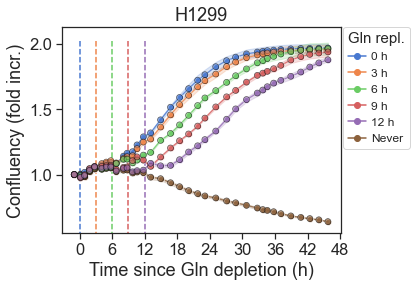

In [16]:
plate_name_sele = 'AS_P26'

row_found = False
for _, row in plate_anno.iterrows():
    if row['Plate name'] == plate_name_sele:
        row_found = True
        break
assert(row_found)
    
fnam, pnam = row['Folder name'], row['Plate name']
Nmes_pre, t_to_mes = row['Nmes pre'], row['Time to mes']

wb_name = '{}/{}/{}_all.xlsx'.format(data_folder, fnam, pnam)
sheet_name = '{}_conf'.format(pnam)
print(wb_name)
#print(sheet_name)
df = pd.read_excel(wb_name, header=1, sheet_name=sheet_name)
# Fix treatment time and mask useless timepoints:
df['Elapsed'] = df['Elapsed'] - df['Elapsed'].values[Nmes_pre] + t_to_mes
time_mask = df['Elapsed'] < row['max time']
df = df[time_mask].copy()

# Find the columns for the plate:
df_melt = df.melt(['Date Time', 'Elapsed'], value_name='conf', var_name='Well')
well_ids = natsorted(list(set(df_melt['Well'])))



df_melt = df.melt(['Date Time', 'Elapsed'], value_name='conf', var_name='Well')
df_melt = df_melt[~df_melt.isna()].copy()
df_norm = df.copy()
df_norm.loc[:, well_ids] = df.loc[:, well_ids] / df.loc[0, well_ids]
df_norm_melt = df_norm.melt(['Date Time', 'Elapsed'], value_name='conf', var_name='Well')
df_norm_melt = df_norm_melt[~df_norm_melt.isna()].copy()
anno_mask = (well_anno['Folder name'] == fnam) & (well_anno['Plate name'] == pnam)
plate_data = well_anno[anno_mask].merge(df_melt, on='Well').reset_index(drop=True)
plate_data_norm = well_anno[anno_mask].merge(df_norm_melt, on='Well').reset_index(drop=True)
plate_data['conf norm'] = plate_data_norm['conf'].copy()
# Remove non-included wells:
plate_data = plate_data[plate_data['include']].copy()
grp_cols = list(set(plate_data.columns) - set(['conf', 'conf norm', 'Well']))
plate_data_avg = plate_data.groupby(grp_cols).agg(conf_mean=('conf', 'mean'), 
                                                  conf_std=('conf', 'std'), 
                                                  conf_norm_mean=('conf norm', 'mean'), 
                                                  conf_norm_std=('conf norm', 'std')).reset_index()


style = 'Drug'
markers = True
pmode = 'conf norm'
pmode_avg = 'conf_norm_mean'
min_sens = plate_data[pmode].min()
max_sens = plate_data[pmode].max()
hue_order = natsorted(set(plate_data['conc_time']))
hue_order.append(hue_order.pop(0))
hue_order_lab = ['0 h', '3 h', '6 h', '9 h', '12 h', 'Never']
h2l = {k:v for k, v in zip(hue_order, hue_order_lab)}
plate_data['legend_lab'] = [h2l[ct] for ct in plate_data['conc_time']]
plate_data_avg['legend_lab'] = [h2l[ct] for ct in plate_data_avg['conc_time']]

fig, ax1 = plt.subplots(1, 1, figsize=(5, 3.8))
g1 = sns.lineplot(ax=ax1, data=plate_data, y=pmode, x='Elapsed', hue='legend_lab', style='legend_lab', \
                  zorder=9, alpha=0.8, linewidth=1.3, legend=True, \
                  errorbar=('ci', row['ci']), hue_order=hue_order_lab, \
                  markers=["o"]*len(hue_order), dashes=[""]*len(hue_order))

g2 = sns.scatterplot(ax=ax1, data=plate_data_avg, y=pmode_avg, x='Elapsed', hue='legend_lab', \
                     zorder=10, alpha=0.6, edgecolor='black', linewidth=0.7, \
                     legend=False, markers=markers, style=style, hue_order=hue_order_lab)

g2.set_ylabel('Confluency (fold incr.)')
g2.set_xlabel('Time since Gln depletion (h)')
g2.set_title('H1299')
sns.move_legend(g2, "upper left", bbox_to_anchor=(1.01, 1), frameon=True, ncol=1, \
                alignment='left', labelspacing=0.5, handletextpad=0.4, borderaxespad=0, \
                handlelength=1.5, title='Gln repl.', fontsize=12, title_fontsize=15)


cmap = sns.color_palette()
for dt, col in zip([0, 3, 6, 9, 12], list(cmap)):
    #ax1.vlines(dt, max_sens, -0.1, ls='--', color='grey')
    ax1.vlines(dt, max_sens, -0.1, ls='--', color=col)
g2.set_ylim(0.55, g2.get_ylim()[1])
# g2.set_xticks([0, 5, 10, 15, 20, 25, 30, 35, 40, 45])
#g2.set_xticks([0, 10, 20, 30, 40])
g2.set_xticks([0, 6, 12, 18, 24, 30, 36, 42, 48])


pdf_fnam = 'temporal_plots/{}_conf.pdf'.format(plate_name_sele)
fig.savefig(pdf_fnam, bbox_inches='tight')

IC_data/AS_P26/AS_P26_all.xlsx


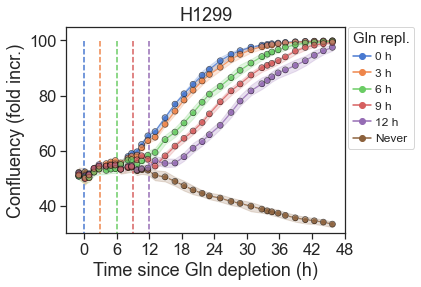

In [6]:
plate_name_sele = 'AS_P26'

row_found = False
for _, row in plate_anno.iterrows():
    if row['Plate name'] == plate_name_sele:
        row_found = True
        break
assert(row_found)
    
fnam, pnam = row['Folder name'], row['Plate name']
Nmes_pre, t_to_mes = row['Nmes pre'], row['Time to mes']

wb_name = '{}/{}/{}_all.xlsx'.format(data_folder, fnam, pnam)
sheet_name = '{}_conf'.format(pnam)
print(wb_name)
#print(sheet_name)
df = pd.read_excel(wb_name, header=1, sheet_name=sheet_name)
# Fix treatment time and mask useless timepoints:
df['Elapsed'] = df['Elapsed'] - df['Elapsed'].values[Nmes_pre] + t_to_mes
time_mask = df['Elapsed'] < row['max time']
df = df[time_mask].copy()

# Find the columns for the plate:
df_melt = df.melt(['Date Time', 'Elapsed'], value_name='conf', var_name='Well')
well_ids = natsorted(list(set(df_melt['Well'])))



df_melt = df.melt(['Date Time', 'Elapsed'], value_name='conf', var_name='Well')
df_melt = df_melt[~df_melt.isna()].copy()
df_norm = df.copy()
df_norm.loc[:, well_ids] = df.loc[:, well_ids] / df.loc[0, well_ids]
df_norm_melt = df_norm.melt(['Date Time', 'Elapsed'], value_name='conf', var_name='Well')
df_norm_melt = df_norm_melt[~df_norm_melt.isna()].copy()
anno_mask = (well_anno['Folder name'] == fnam) & (well_anno['Plate name'] == pnam)
plate_data = well_anno[anno_mask].merge(df_melt, on='Well').reset_index(drop=True)
plate_data_norm = well_anno[anno_mask].merge(df_norm_melt, on='Well').reset_index(drop=True)
plate_data['conf norm'] = plate_data_norm['conf'].copy()
# Remove non-included wells:
plate_data = plate_data[plate_data['include']].copy()
grp_cols = list(set(plate_data.columns) - set(['conf', 'conf norm', 'Well']))
plate_data_avg = plate_data.groupby(grp_cols).agg(conf_mean=('conf', 'mean'), 
                                                  conf_std=('conf', 'std'), 
                                                  conf_norm_mean=('conf norm', 'mean'), 
                                                  conf_norm_std=('conf norm', 'std')).reset_index()


style = 'Drug'
markers = True
pmode = 'conf'
pmode_avg = 'conf_mean'
min_sens = plate_data[pmode].min()
max_sens = plate_data[pmode].max()
hue_order = natsorted(set(plate_data['conc_time']))
hue_order.append(hue_order.pop(0))
hue_order_lab = ['0 h', '3 h', '6 h', '9 h', '12 h', 'Never']
h2l = {k:v for k, v in zip(hue_order, hue_order_lab)}
plate_data['legend_lab'] = [h2l[ct] for ct in plate_data['conc_time']]
plate_data_avg['legend_lab'] = [h2l[ct] for ct in plate_data_avg['conc_time']]

fig, ax1 = plt.subplots(1, 1, figsize=(5, 3.8))
g1 = sns.lineplot(ax=ax1, data=plate_data, y=pmode, x='Elapsed', hue='legend_lab', style='legend_lab', \
                  zorder=9, alpha=0.8, linewidth=1.3, legend=True, \
                  errorbar=('ci', row['ci']), hue_order=hue_order_lab, \
                  markers=["o"]*len(hue_order), dashes=[""]*len(hue_order))

g2 = sns.scatterplot(ax=ax1, data=plate_data_avg, y=pmode_avg, x='Elapsed', hue='legend_lab', \
                     zorder=10, alpha=0.6, edgecolor='black', linewidth=0.7, \
                     legend=False, markers=markers, style=style, hue_order=hue_order_lab)

g2.set_ylabel('Confluency (fold incr.)')
g2.set_xlabel('Time since Gln depletion (h)')
g2.set_title('H1299')
sns.move_legend(g2, "upper left", bbox_to_anchor=(1.01, 1), frameon=True, ncol=1, \
                alignment='left', labelspacing=0.5, handletextpad=0.4, borderaxespad=0, \
                handlelength=1.5, title='Gln repl.', fontsize=12, title_fontsize=15)


cmap = sns.color_palette()
for dt, col in zip([0, 3, 6, 9, 12], list(cmap)):
    #ax1.vlines(dt, max_sens, -0.1, ls='--', color='grey')
    ax1.vlines(dt, max_sens, -0.1, ls='--', color=col)
g2.set_ylim(30, g2.get_ylim()[1])
# g2.set_xticks([0, 5, 10, 15, 20, 25, 30, 35, 40, 45])
#g2.set_xticks([0, 10, 20, 30, 40])
g2.set_xticks([0, 6, 12, 18, 24, 30, 36, 42, 48])


pdf_fnam = 'temporal_plots/{}_conf_unnorm.pdf'.format(plate_name_sele)
fig.savefig(pdf_fnam, bbox_inches='tight')

### HT1080 Nuc-RFP Asp-sens oligomycin rescued with BAM15

IC_data/AS_P30/AS_P30_all.xlsx


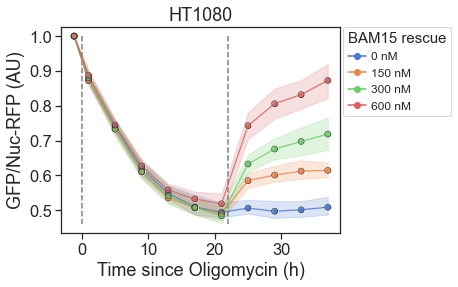

In [9]:
plate_name_sele = 'AS_P30'


row_found = False
for _, row in plate_anno.iterrows():
    if row['Plate name'] == plate_name_sele:
        row_found = True
        break
assert(row_found)
    
fnam, pnam = row['Folder name'], row['Plate name']
Nmes_pre, t_to_mes = row['Nmes pre'], row['Time to mes']

wb_name = '{}/{}/{}_all.xlsx'.format(data_folder, fnam, pnam)
sheet_name = '{}_GFP-RFP'.format(pnam)
sheet_name_rfp = '{}_RFP'.format(pnam)
print(wb_name)
#print(sheet_name)
df = pd.read_excel(wb_name, header=1, sheet_name=sheet_name)
# Fix treatment time and mask useless timepoints:
df['Elapsed'] = df['Elapsed'] - df['Elapsed'].values[Nmes_pre] + t_to_mes
time_mask = df['Elapsed'] < row['max time']
df = df[time_mask].copy()

# Find the columns for the plate:
df_melt = df.melt(['Date Time', 'Elapsed'], value_name='GFP/RFP', var_name='Well')
well_ids = natsorted(list(set(df_melt['Well'])))

# Mask timepoint with confluent cells:
df_rfp = pd.read_excel(wb_name, header=1, sheet_name=sheet_name_rfp)
df_rfp = df_rfp[time_mask].copy()
df_rfp.loc[:, well_ids] = df_rfp.loc[:, well_ids] / df_rfp.loc[0, well_ids]

cut_mask = df_rfp.loc[:, well_ids] < row['rfp fold cut']
df.loc[:, well_ids] = df.loc[:, well_ids][cut_mask].copy()


df_melt = df.melt(['Date Time', 'Elapsed'], value_name='GFP/RFP', var_name='Well')
df_melt = df_melt[~df_melt.isna()].copy()
df_norm = df.copy()
df_norm.loc[:, well_ids] = df.loc[:, well_ids] / df.loc[0, well_ids]
df_norm_melt = df_norm.melt(['Date Time', 'Elapsed'], value_name='GFP/RFP', var_name='Well')
df_norm_melt = df_norm_melt[~df_norm_melt.isna()].copy()
anno_mask = (well_anno['Folder name'] == fnam) & (well_anno['Plate name'] == pnam)
plate_data = well_anno[anno_mask].merge(df_melt, on='Well').reset_index(drop=True)
plate_data_norm = well_anno[anno_mask].merge(df_norm_melt, on='Well').reset_index(drop=True)
plate_data['GFP/RFP norm'] = plate_data_norm['GFP/RFP'].copy()
# Remove non-included wells:
plate_data = plate_data[plate_data['include']].copy()
grp_cols = list(set(plate_data.columns) - set(['GFP/RFP', 'GFP/RFP norm', 'Well']))
plate_data_avg = plate_data.groupby(grp_cols).agg(GFP_RFP_mean=('GFP/RFP', 'mean'), 
                                                  GFP_RFP_std=('GFP/RFP', 'std'), 
                                                  GFP_RFP_norm_mean=('GFP/RFP norm', 'mean'), 
                                                  GFP_RFP_norm_std=('GFP/RFP norm', 'std')).reset_index()


# Apply mask to remove vehicle treated,
# since these wells get over-confluent:
mask = (plate_data['Drug'] != 'Vec')
plate_data = plate_data[mask]

mask = (plate_data_avg['Drug'] != 'Vec')
plate_data_avg = plate_data_avg[mask]


style = 'Cell line'
markers = True
pmode = 'GFP/RFP norm'
pmode_avg = 'GFP_RFP_norm_mean'
min_sens = plate_data[pmode].min()
max_sens = plate_data[pmode].max()
hue_order = natsorted(set(plate_data['conc_resc']))
#hue_order.insert(0, hue_order.pop(-1))

fig, ax1 = plt.subplots(1, 1, figsize=(5, 3.8))
g1 = sns.lineplot(ax=ax1, data=plate_data, y=pmode, x='Elapsed', hue='conc_resc', style='conc_resc', \
                  zorder=9, alpha=0.8, linewidth=1.3, legend=True, \
                  errorbar=('ci', row['ci']), hue_order=hue_order, \
                  markers=["o"]*len(hue_order), dashes=[""]*len(hue_order))

g2 = sns.scatterplot(ax=ax1, data=plate_data_avg, y=pmode_avg, x='Elapsed', hue='conc_resc', \
                     zorder=10, alpha=0.6, edgecolor='black', linewidth=0.7, \
                     legend=False, markers=markers, style=style, hue_order=hue_order)

g2.set_ylabel('GFP/Nuc-RFP (AU)')
g2.set_xlabel('Time since Oligomycin (h)')
g2.set_title('HT1080')
sns.move_legend(g2, "upper left", bbox_to_anchor=(1.01, 1), frameon=True, ncol=1, \
                alignment='left', labelspacing=0.5, handletextpad=0.4, borderaxespad=0, \
                handlelength=1.5, title='BAM15 rescue', fontsize=12, title_fontsize=15)

for dt in [0, 22]:
    ax1.vlines(dt, max_sens, min_sens, ls='--', color='grey')


pdf_fnam = 'temporal_plots/{}.pdf'.format(plate_name_sele)
fig.savefig(pdf_fnam, bbox_inches='tight')

### HT1080 Nuc-RFP Asp-sens rotenone and pyruvate rescue after some time

IC_data/AS_P29/AS_P29_all.xlsx


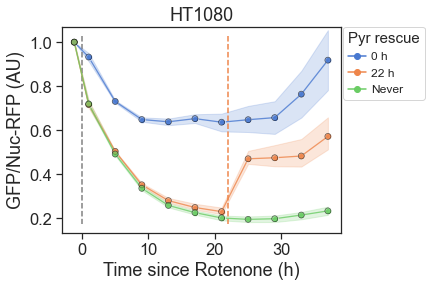

In [10]:
plate_name_sele = 'AS_P29'


row_found = False
for _, row in plate_anno.iterrows():
    if row['Plate name'] == plate_name_sele:
        row_found = True
        break
assert(row_found)
    
fnam, pnam = row['Folder name'], row['Plate name']
Nmes_pre, t_to_mes = row['Nmes pre'], row['Time to mes']

wb_name = '{}/{}/{}_all.xlsx'.format(data_folder, fnam, pnam)
sheet_name = '{}_GFP-RFP'.format(pnam)
sheet_name_rfp = '{}_RFP'.format(pnam)
print(wb_name)
#print(sheet_name)
df = pd.read_excel(wb_name, header=1, sheet_name=sheet_name)
# Fix treatment time and mask useless timepoints:
df['Elapsed'] = df['Elapsed'] - df['Elapsed'].values[Nmes_pre] + t_to_mes
time_mask = df['Elapsed'] < row['max time']
df = df[time_mask].copy()

# Find the columns for the plate:
df_melt = df.melt(['Date Time', 'Elapsed'], value_name='GFP/RFP', var_name='Well')
well_ids = natsorted(list(set(df_melt['Well'])))

# Mask timepoint with confluent cells:
df_rfp = pd.read_excel(wb_name, header=1, sheet_name=sheet_name_rfp)
df_rfp = df_rfp[time_mask].copy()
df_rfp.loc[:, well_ids] = df_rfp.loc[:, well_ids] / df_rfp.loc[0, well_ids]

cut_mask = df_rfp.loc[:, well_ids] < row['rfp fold cut']
df.loc[:, well_ids] = df.loc[:, well_ids][cut_mask].copy()


df_melt = df.melt(['Date Time', 'Elapsed'], value_name='GFP/RFP', var_name='Well')
df_melt = df_melt[~df_melt.isna()].copy()
df_norm = df.copy()
df_norm.loc[:, well_ids] = df.loc[:, well_ids] / df.loc[0, well_ids]
df_norm_melt = df_norm.melt(['Date Time', 'Elapsed'], value_name='GFP/RFP', var_name='Well')
df_norm_melt = df_norm_melt[~df_norm_melt.isna()].copy()
anno_mask = (well_anno['Folder name'] == fnam) & (well_anno['Plate name'] == pnam)
plate_data = well_anno[anno_mask].merge(df_melt, on='Well').reset_index(drop=True)
plate_data_norm = well_anno[anno_mask].merge(df_norm_melt, on='Well').reset_index(drop=True)
plate_data['GFP/RFP norm'] = plate_data_norm['GFP/RFP'].copy()
# Remove non-included wells:
plate_data = plate_data[plate_data['include']].copy()
grp_cols = list(set(plate_data.columns) - set(['GFP/RFP', 'GFP/RFP norm', 'Well']))
plate_data_avg = plate_data.groupby(grp_cols).agg(GFP_RFP_mean=('GFP/RFP', 'mean'), 
                                                  GFP_RFP_std=('GFP/RFP', 'std'), 
                                                  GFP_RFP_norm_mean=('GFP/RFP norm', 'mean'), 
                                                  GFP_RFP_norm_std=('GFP/RFP norm', 'std')).reset_index()


# Apply mask to remove vehicle treated,
# since these wells get over-confluent:
mask = (plate_data['Drug'] != 'Vec')
plate_data = plate_data[mask]

mask = (plate_data_avg['Drug'] != 'Vec')
plate_data_avg = plate_data_avg[mask]


style = 'Cell line'
markers = True
pmode = 'GFP/RFP norm'
pmode_avg = 'GFP_RFP_norm_mean'
min_sens = plate_data[pmode].min()
max_sens = plate_data[pmode].max()
'''
hue_order = [
 'Vec & Vec - 0 h',
 'Vec & Pyr - 0 h',
 'Vec & Pyr - 22 h',
 'Rot & Vec - 0 h',
 'Rot & Pyr - 0 h',
 'Rot & Pyr - 22 h']
'''
hue_order = [
 'Rot & Pyr - 0 h',
 'Rot & Pyr - 22 h',
 'Rot & Vec - 0 h']
hue_order_lab = ['0 h', '22 h', 'Never']
h2l = {k:v for k, v in zip(hue_order, hue_order_lab)}
plate_data['legend_lab'] = [h2l[ct] for ct in plate_data['drug_resc_time']]
plate_data_avg['legend_lab'] = [h2l[ct] for ct in plate_data_avg['drug_resc_time']]


fig, ax1 = plt.subplots(1, 1, figsize=(5, 3.8))
g1 = sns.lineplot(ax=ax1, data=plate_data, y=pmode, x='Elapsed', hue='legend_lab', style='legend_lab', \
                  zorder=9, alpha=0.8, linewidth=1.3, legend=True, \
                  errorbar=('ci', row['ci']), hue_order=hue_order_lab, \
                  markers=["o"]*len(hue_order), dashes=[""]*len(hue_order))

g2 = sns.scatterplot(ax=ax1, data=plate_data_avg, y=pmode_avg, x='Elapsed', hue='legend_lab', \
                     zorder=10, alpha=0.6, edgecolor='black', linewidth=0.7, \
                     legend=False, markers=markers, style=style, hue_order=hue_order_lab)

g2.set_ylabel('GFP/Nuc-RFP (AU)')
g2.set_xlabel('Time since Rotenone (h)')
g2.set_title('HT1080')
sns.move_legend(g2, "upper left", bbox_to_anchor=(1.01, 1), frameon=True, ncol=1, \
                alignment='left', labelspacing=0.5, handletextpad=0.4, borderaxespad=0, \
                handlelength=1.5, title='Pyr rescue', fontsize=12, title_fontsize=15)

for col, dt in zip(['grey', list(cmap)[1]], [0, 22]):
    ax1.vlines(dt, 1.03, min_sens, ls='--', color=col)
g2.set_ylim(g2.get_ylim()[0], 1.07)


pdf_fnam = 'temporal_plots/{}.pdf'.format(plate_name_sele)
fig.savefig(pdf_fnam, bbox_inches='tight')